In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [18]:
fig_out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures"
analyze_comethylation = compute_comethylation.analyzeComethylation()

# Read TCGA

In [3]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [4]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/comparison_sites*")

In [6]:
all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    all_comparison_site_dfs.append(one_comp_df)
corr_all_comparison_site_df = pd.concat(all_comparison_site_dfs)
corr_all_comparison_site_df.reset_index(inplace=True, drop=True)

In [21]:
all_metrics_dfs = []
"""for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path, 
                                     columns = ['delta_mf_median', 'mutated_sample', 'mut_event', 'is_background', 'index_event', 'measured_site', 'measured_site_dist']
                                     )
    one_metrics_df = one_metrics_dd.compute()
    one_metrics_df = one_metrics_df.loc[one_metrics_df["mutated_sample"] == True]
    all_metrics_dfs.append(one_metrics_df)
corr_all_metrics_df = pd.concat(all_metrics_dfs)
corr_all_metrics_df.reset_index(inplace=True, drop=True)
corr_all_metrics_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/corr_all_metrics_no_matchedSample.parquet")"""
corr_all_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/all_metrics_combined.parquet")

In [5]:
tcga_corr_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/corr_mean_metrics_w_mut_info_df_10correl.parquet')

In [ ]:
"""mean_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/mean_metrics*Muts.parquet")
corr_mean_metrics_dfs = []
for path in mean_paths:
    one_mean_df = pd.read_parquet(path)
    corr_mean_metrics_dfs.append(one_mean_df)
corr_mean_metrics_df = pd.concat(corr_mean_metrics_dfs)
corr_mean_metrics_df.reset_index(inplace=True, drop=True)
corr_mean_metrics_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/mean_metrics_by_dist.parquet")"""
corr_mean_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_comethyl_output/corr_1000sites/mean_metrics_by_dist.parquet")

In [9]:
tcga_corr_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10")['mut_event'].nunique()

2484

In [15]:
tcga_corr_mean_metrics_w_annot_df['DNA_VAF'].min()

0.09

In [12]:
corr_mean_metrics_df.query("is_background == True and mutated_sample == True")['mut_event'].nunique()

248369

In [13]:
corr_mean_metrics_df.query("is_background == True and mutated_sample == True")['mut_event'].nunique() / corr_mean_metrics_df.query("is_background == False and mutated_sample == True")['mut_event'].nunique()

99.98752012882447

# Read ICGC data

In [2]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [5]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/comparison_sites*")
m_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/mean_metrics*")

In [6]:
# mean metrics
icgc_corr_mean_metrics_df_l = []
for path in m_paths:
    # read in metrics sites from dask paruet
    one_metrics_df = pd.read_parquet(path)
    icgc_corr_mean_metrics_df_l.append(one_metrics_df)
icgc_corr_mean_metrics_df = pd.concat(icgc_corr_mean_metrics_df_l)

In [ ]:
#icgc_corr_mean_metrics_w_annot_df = analyze_comethylation.add_mutation_info_to_mean_metrics_df(icgc_corr_mean_metrics_df, distance = 10, consortium = 'ICGC')
#icgc_corr_mean_metrics_w_annot_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/corr_mean_metrics10Dist.parquet')
icgc_corr_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/corr_mean_metrics10Dist.parquet')
icgc_corr_mean_metrics_w_annot_df.drop_duplicates(['mut_event'], inplace=True)

In [8]:
icgc_corr_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True")['mut_event'].nunique()

873

In [22]:
icgc_corr_all_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/all_metrics_combined.parquet')

# Mutation counts and VAF

In [26]:
icgc_corr_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and DNA_VAF >= .1")['mut_event'].value_counts()

DO229396_3:50316384      1
DO229527_7:56515601      1
DO6378_3:146129420       1
DO6394_2:205189476       1
DO229395_11:122753049    1
                        ..
DO46358_6:31936247       1
DO46360_2:139465825      1
DO46368_15:35414083      1
DO46368_20:44258197      1
DO6549_1:11543556        1
Name: mut_event, Length: 800, dtype: int64

<Axes: >

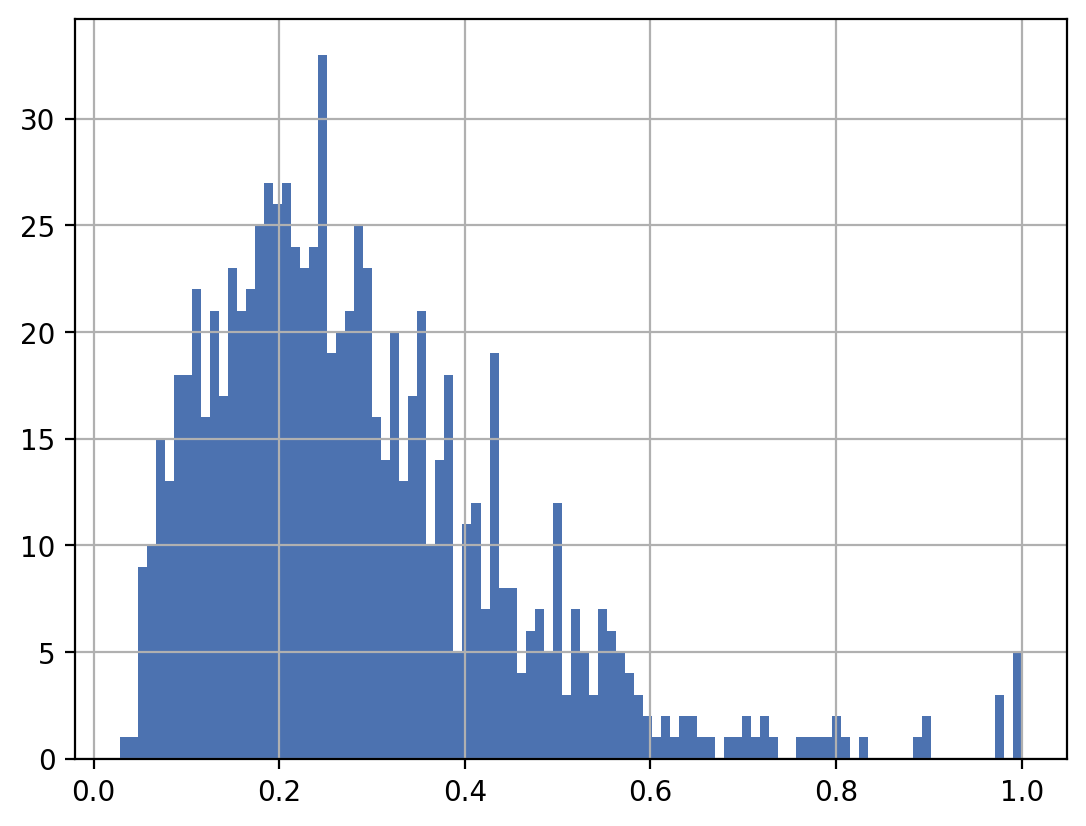

In [22]:
icgc_corr_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and")['DNA_VAF'].hist(bins = 100)

In [27]:
tcga_corr_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True")['DNA_VAF'].min()

0.38

# B) violin of methylation-correlation vs distance

#### TCGA

In [138]:
chr1_cpgs = illumina_cpg_locs_df.loc[illumina_cpg_locs_df['chr'] == '1', '#id'].values
chr1_w_methyl_cpgs = set(chr1_cpgs).intersection(set(all_methyl_age_df_t.columns))
# chr1_dist_df = utils.get_distances_one_chrom_new('1', illumina_cpg_locs_df)
chr1_dist_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/dependency_files/all_distances_chrom1_PANCAN.parquet')
chr1_corrs = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/dependency_files/all_corrs_chrom1_PANCAN.parquet')

NameError: name 'all_methyl_age_df_t' is not defined

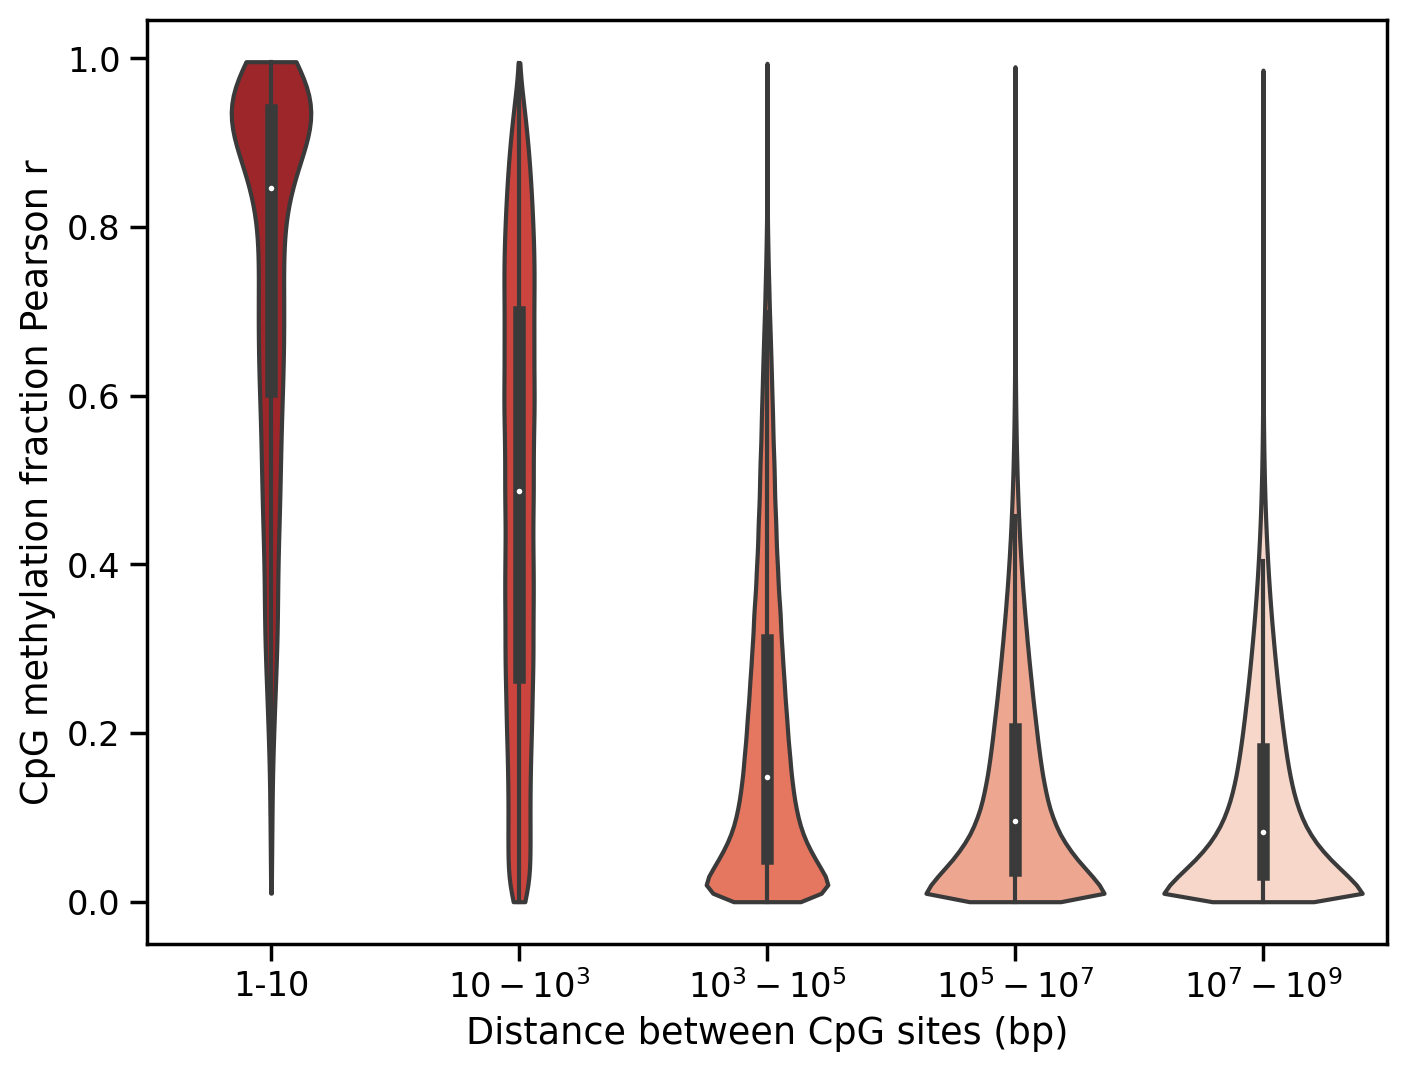

In [ ]:
utils.plot_corr_vs_dist(
    np.abs(chr1_corrs),
    chr1_dist_df.loc[chr1_corrs.index, chr1_corrs.columns],
    out_fn = os.path.join(fig_out_dir, 'figure4', 'fig4B_corrs_vs_dist_TCGA1.svg')
    )

#### ICGC

In [23]:
chr1_cpgs = illumina_cpg_locs_df.loc[illumina_cpg_locs_df['chr'] == '1', '#id'].values
chr1_w_methyl_cpgs = set(chr1_cpgs).intersection(set(icgc_methyl_age_df_t.columns))
chr1_dist_df = utils.get_distances_one_chrom_new('1', illumina_cpg_locs_df)

In [24]:
chr1_corrs_prad = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/final_icgc_data/chr_dset_corrs_qnorm/chr1_PRAD.parquet')

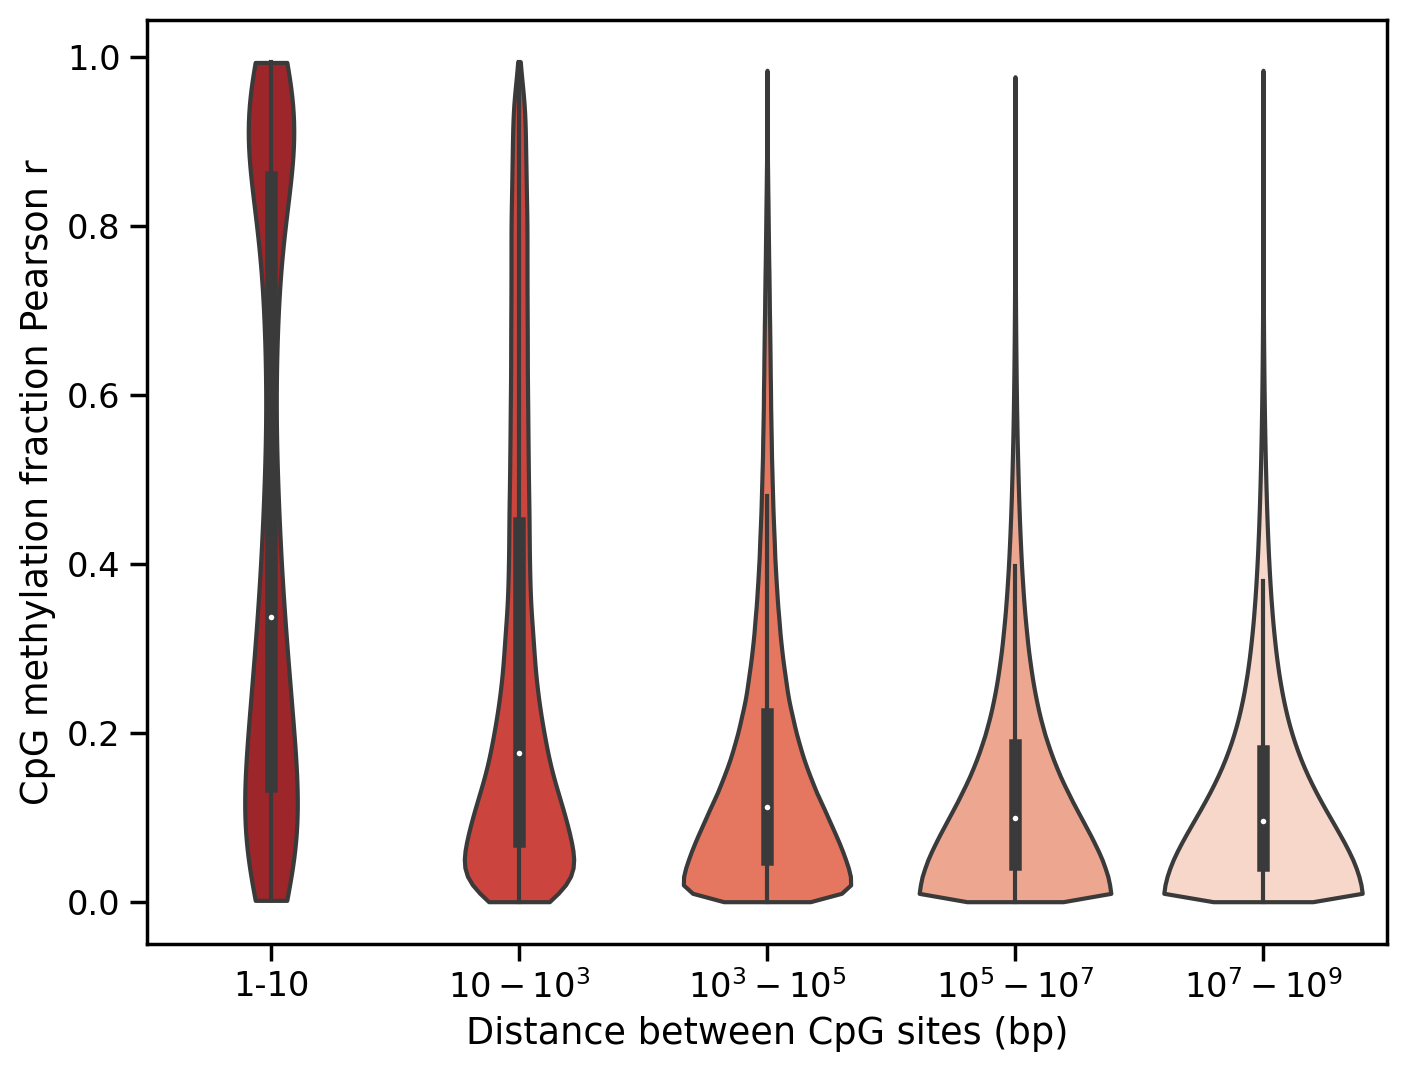

In [25]:
utils.plot_corr_vs_dist(
    np.abs(chr1_corrs_prad), 
    chr1_dist_df.loc[chr1_corrs_prad.index, chr1_corrs_prad.columns],
    out_fn = os.path.join(fig_out_dir, 'figure4', 'fig4B_prad_corrs_vs_dist_PRAD1.svg')
    )

# Supp Supernova heatmap

0 1 1


/cellar/users/zkoch/methylation_and_mutation/source_files/compute_comethylation.py:1012: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2 = ax.twinx()


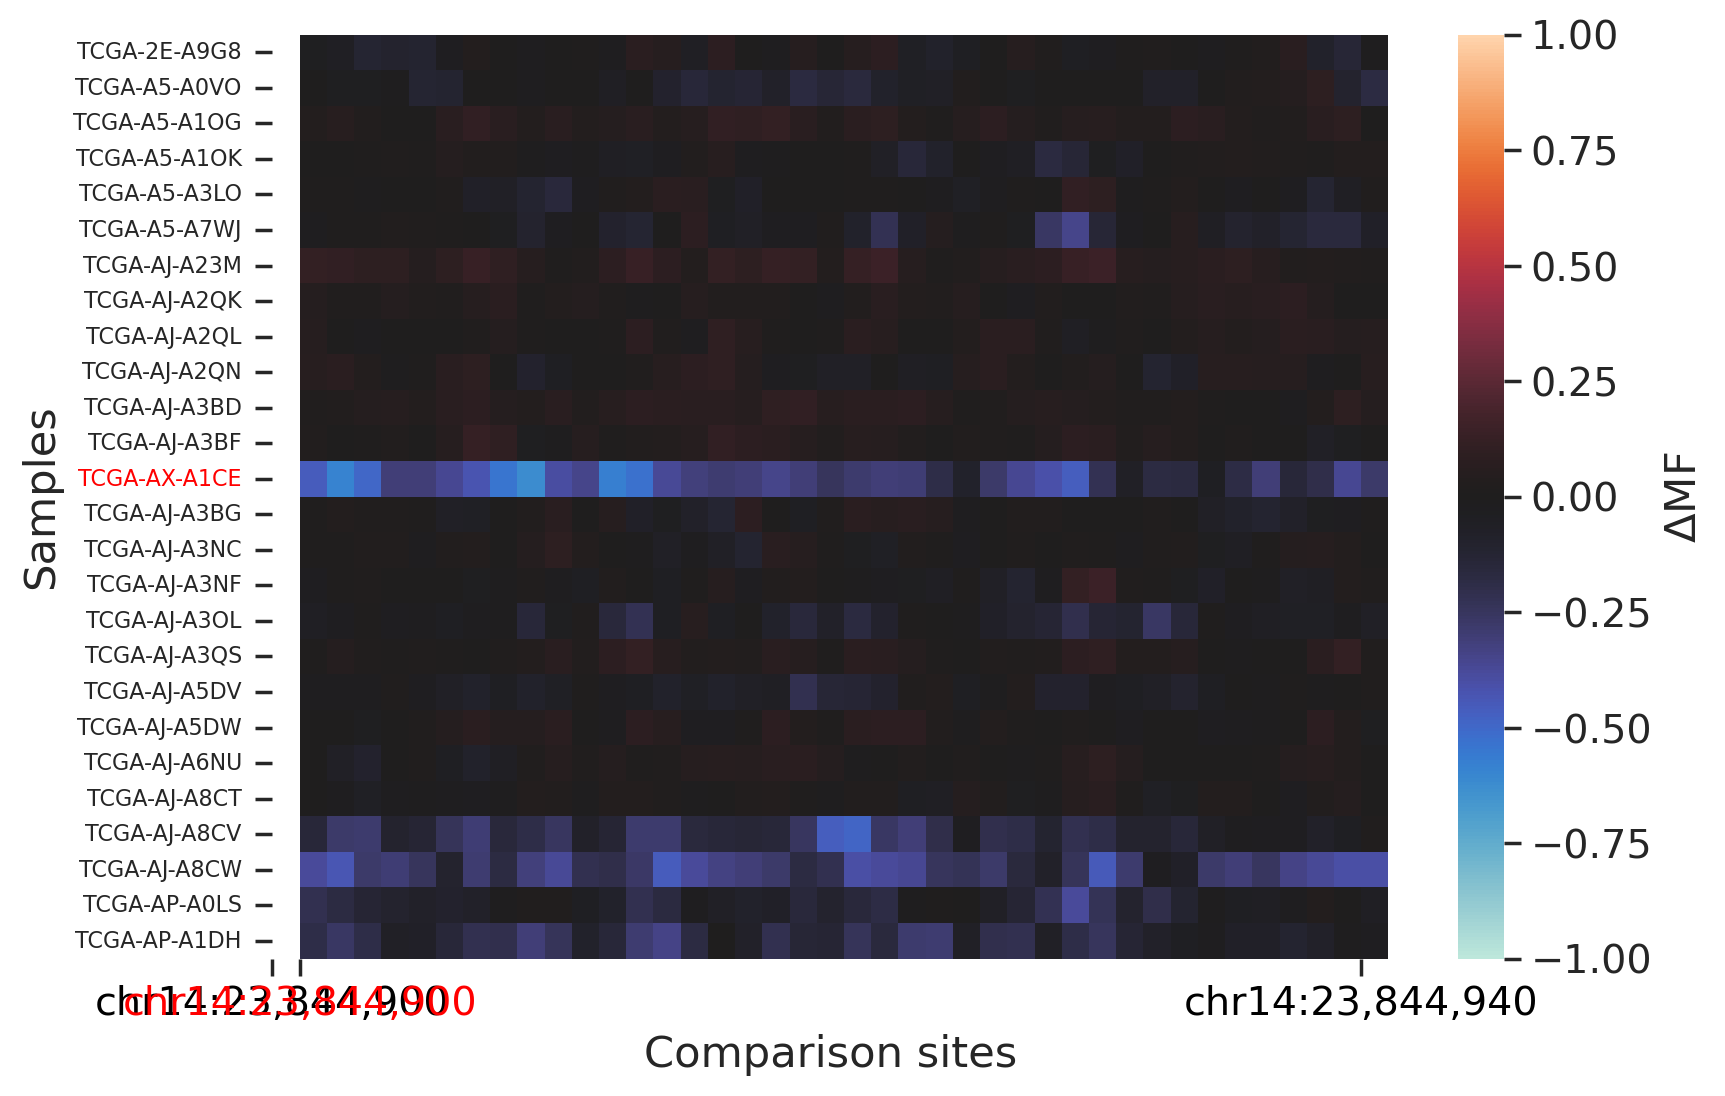

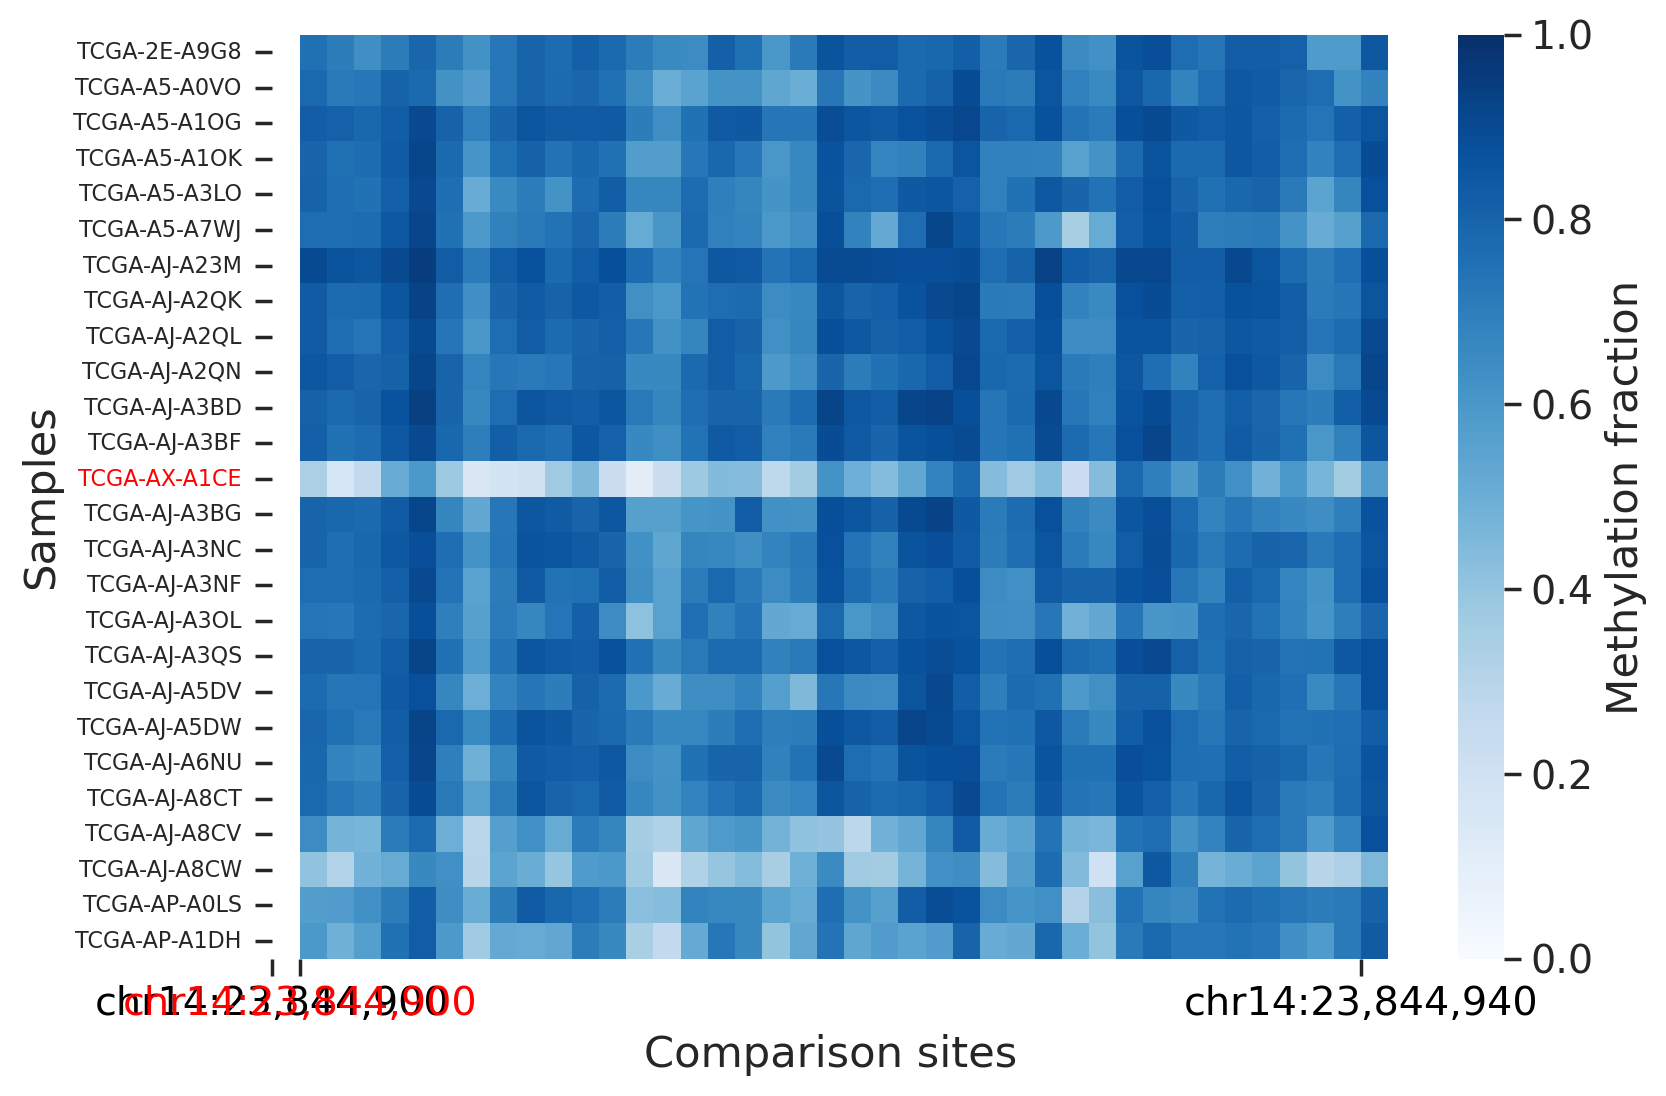

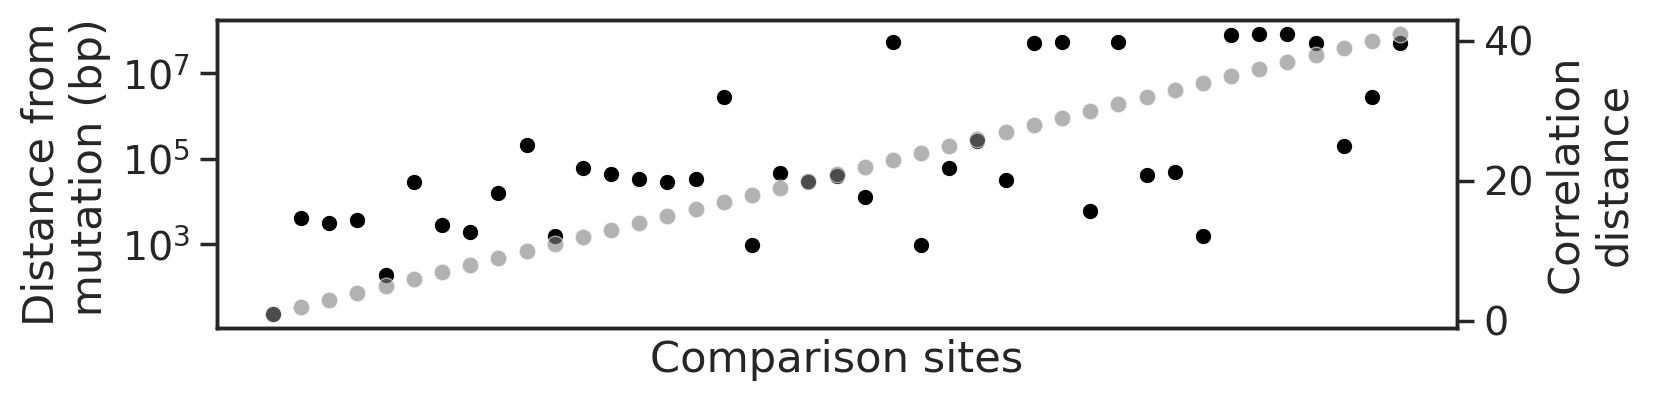

In [34]:
# best:TCGA-AX-A1CE_14:23844900	w/ max_abs_distance = 60 and max_matched_samples = 30
all_samples_comp_sites, all_samples_comp_sites_dmf, comparison_site_and_distances = analyze_comethylation.plot_heatmap_dist(
    mut_event = "TCGA-AX-A1CE_14:23844900",
    comparison_sites_df = corr_all_comparison_site_df,all_methyl_age_df_t = all_methyl_age_df_t, 
    illumina_cpg_locs_df = illumina_cpg_locs_df, method = 'corr',
    max_abs_distance = 40, max_matched_samples = 25, rolling_window_size = 2
)

# Supp DMF KDE plots and boxplots

In [32]:
icgc_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 or is_background == True").query("is_background == False and mutated_sample == True")['mut_event'].nunique()

800

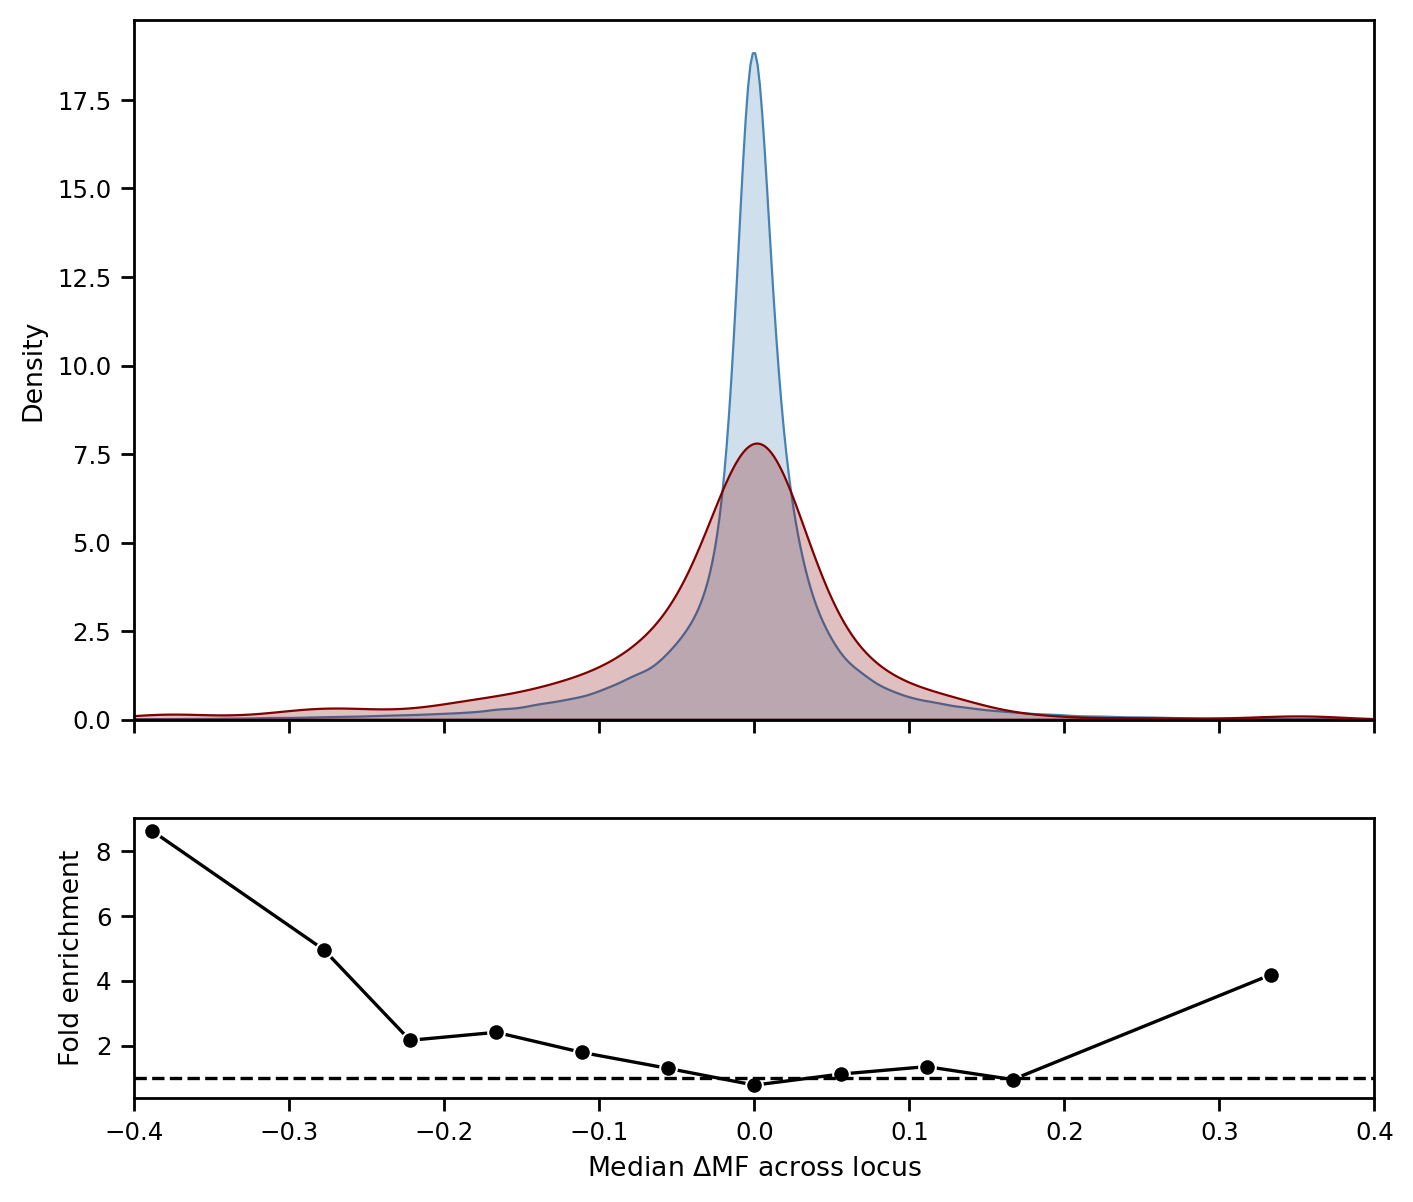

In [36]:
# make second axes bigger kw
fig, axes = plt.subplots(2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True)
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    icgc_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 or is_background == True"),
    metric = 'median_dmf', axes = axes,
    consortium = 'ICGC', out_fn ="/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental/supp_DMF_kde_corr_icgc.svg" # also figure4/DMF_kde_corr_icgc.svg
    ) # change min counts to 5

In [13]:
from scipy.stats import mannwhitneyu
mannwhitneyu(icgc_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 and is_background == False and mutated_sample == True and distance == 10")['median_dmf'], icgc_corr_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10")['median_dmf'])

MannwhitneyuResult(statistic=44907392.5, pvalue=0.00019313034335843756)

In [14]:
mannwhitneyu(icgc_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 and is_background == False and mutated_sample == True and distance == 10")['median_abs_dmf'], icgc_corr_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10")['median_abs_dmf'])

MannwhitneyuResult(statistic=60303934.5, pvalue=8.413143102728159e-32)

In [15]:
mannwhitneyu(icgc_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 and is_background == False and mutated_sample == True and distance == 10")['median_dmf'].abs(), icgc_corr_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10")['median_dmf'].abs())

MannwhitneyuResult(statistic=59412548.5, pvalue=2.2256779382361045e-27)

SignificanceResult(statistic=0.1640799520203927, pvalue=1.1085294245355856e-06)
PearsonRResult(statistic=0.19768594358979885, pvalue=3.922774174079492e-09)


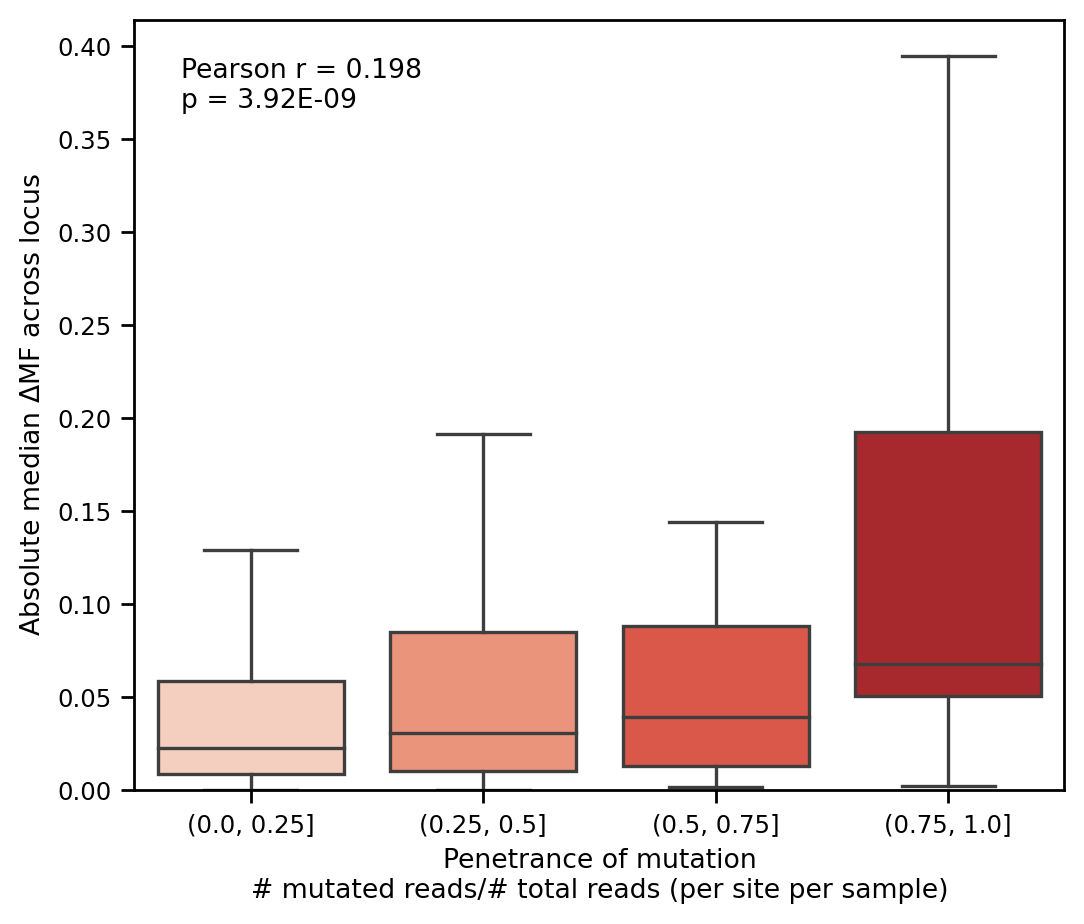

In [137]:
filtered_df = icgc_corr_mean_metrics_w_annot_df.query(
    'distance == 10 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
num_top_muts = int(873/2) # 15%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
largest_eff_df = pd.concat([top_df, bottom_df])

fig, axes = plt.subplots(figsize = (6,5), dpi = 100)
sns.set_context('paper')

# bin by DNA VAF
largest_eff_df['DNA_VAF_bin'] = pd.cut(
    largest_eff_df['DNA_VAF'],
    bins = pd.IntervalIndex.from_tuples([(0,.25), (.25, .5), (.5, .75), (.75, 1)])
        #[(0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1)])
    )
# get absolute value of median dmf
largest_eff_df['abs_median_dmf'] = largest_eff_df['median_dmf'].abs()
# boxplot
sns.boxplot(
    data=largest_eff_df.query("is_background == False"),
    x='DNA_VAF_bin', y='abs_median_dmf', showfliers=False, palette = 'Reds',
    ax = axes
    )
# corrs, median_abs_dmf is better than abs_median_dmf
print(spearmanr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf']))
print(pearsonr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf']))
# add pearson r and pvalue to upper left corner)
r,p = pearsonr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf'])
# add pearson r and pvalue to upper left corner
axes.text(
    0.05, 0.95, f'Pearson r = {round(r,3)}\np = {p:.2E}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
    )
axes.set_ylabel('Absolute median $\Delta$MF across locus')
axes.set_xlabel('Penetrance of mutation\n# mutated reads/# total reads (per site per sample)')
# include 0 on y axis
axes.set_ylim(bottom=0)
plt.savefig(os.path.join(fig_out_dir, 'supplemental', 'S13_DNAVAF_vs_absDMF_boxplot_corr_ICGC.svg'), dpi = 300, format = 'svg')


Text(0.5, 0, 'Median $\\Delta$MF')

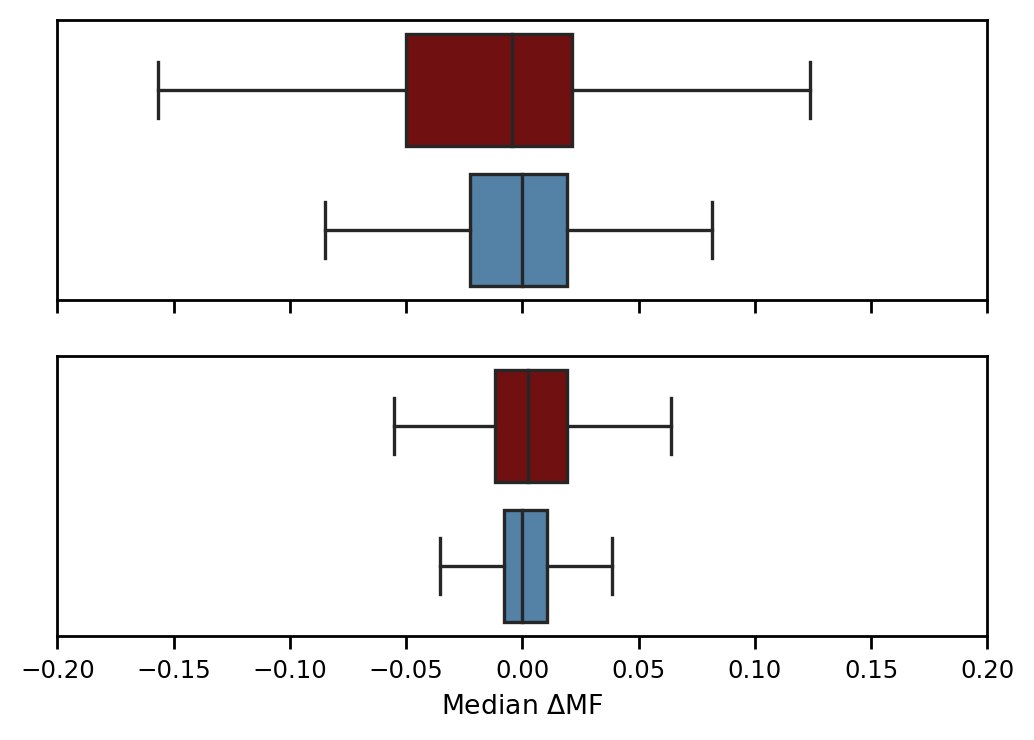

In [6]:
# 10
# make second axes bigger kw
fig, axes = plt.subplots(2,1, figsize = (6, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels

icgc_corr_mean_metrics_w_annot_df['is_cpg'] = icgc_corr_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
icgc_corr_mean_metrics_w_annot_df['is_cpg'] = icgc_corr_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

icgc_corr_mean_metrics_w_annot_df['is_cgi_renamed'] = icgc_corr_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

icgc_corr_mean_metrics_w_annot_df['combined_category'] = icgc_corr_mean_metrics_w_annot_df['is_cpg'] + '\n' + icgc_corr_mean_metrics_w_annot_df['is_cgi_renamed']

mut = icgc_corr_mean_metrics_w_annot_df.loc[icgc_corr_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
        

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

axes[1].set_xlim(-.2, .2)
for i in range(2):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[1].set_xlabel('Median $\Delta$MF')
plt.savefig(os.path.join(fig_out_dir, 'figure4', 'figure4D_icgc_median_dmf_boxplots.svg'), format='svg', dpi = 300)


In [10]:
mut.query("Locus == 'Mutated'").drop_duplicates('mut_event')['is_cgi'].value_counts()

False    700
True     173
Name: is_cgi, dtype: int64

# E) Corr distance vs. genomic distance

In [76]:
icgc_corr_all_metrics_df['mut_sample'] = icgc_corr_all_metrics_df['mut_event'].str.split('_').str[0]
icgc_corr_all_metrics_df['mut_chr'] =  icgc_corr_all_metrics_df['mut_event'].str.split('_').str[1].str.split(':').str[0]
dset_sample_map = icgc_methyl_age_df_t['dataset'].reset_index()
# create dictionary to map from sample to dataset
mapping_dict = dict(zip(dset_sample_map['sample'], dset_sample_map['dataset']))
icgc_corr_all_metrics_df['mut_sample_dset'] = icgc_corr_all_metrics_df['mut_sample'].map(mapping_dict)
icgc_corr_all_metrics_df = icgc_corr_all_metrics_df.drop_duplicates(subset = ['mut_event', 'measured_site', 'is_background'])

def get_corr_by_mut_event(mut_event_group_df, chr_dset_corr_df):
    # get the mutated CpG
    comp_sites = mut_event_group_df['measured_site']
    mut_cpg_chrom, mut_cpg_start = mut_event_group_df.head(1)['mut_event'].values[0].split('_')[1].split(':')
    mut_cpg_start = int(mut_cpg_start)
    mut_cpg_id = illumina_cpg_locs_df.query('chr == @mut_cpg_chrom and start == @mut_cpg_start')['#id'].values[0]
    # get the correlation of the mutated CpG and comp sites
    corrs = chr_dset_corr_df.loc[mut_cpg_id, comp_sites]
    #corrs.reset_index(inplace=True)
    return corrs

corr_dir = "/cellar/users/zkoch/methylation_and_mutation/data/final_icgc_data/chr_dset_corrs_qnorm"
all_corrs_by_mut_event_dfs = []
icgc_corr_mut_metrics = icgc_corr_all_metrics_df#.query("not is_background")
chroms = icgc_corr_mut_metrics['mut_chr'].unique()
tissues = icgc_corr_mut_metrics['mut_sample_dset'].unique()
print(f"processing {len(chroms)} chroms and {len(tissues)} tissues")
for chrom in chroms:
    for tissue in tissues:
        # and the mutation events
        this_tissue_chr_mut_events = icgc_corr_mut_metrics.query(
            "mut_sample_dset==@tissue & mut_chr==@chrom"
            )
        # skip if none
        if len(this_tissue_chr_mut_events) == 0:
            print(f"no mutations in {tissue} on chr{chrom}")
            continue
        # read in the correlation matrix
        corr_df = pd.read_parquet(os.path.join(corr_dir, f"chr{chrom}_{tissue}.parquet"))
        corrs_by_mut_event_df = this_tissue_chr_mut_events.groupby("mut_event").apply(
                lambda group_df: get_corr_by_mut_event(group_df, corr_df)
            ).reset_index().rename(columns={'level_1': 'measured_site', 0: 'corr'})
        if corrs_by_mut_event_df.shape[0] == 1:
            # pivot so that the 
            corrs_by_mut_event_df = pd.DataFrame({'measured_site': corrs_by_mut_event_df.columns[1:], 'corr':corrs_by_mut_event_df.values[0][1:]})
            corrs_by_mut_event_df['mut_event'] = corrs_by_mut_event_df.iloc[0, 0]
            all_corrs_by_mut_event_dfs.append(corrs_by_mut_event_df)
        else:        
            all_corrs_by_mut_event_dfs.append(corrs_by_mut_event_df)
    print(f"done with chr{chrom}")
all_corrs_by_mut_event_df = pd.concat(all_corrs_by_mut_event_dfs, axis=0)
#icgc_corr_mut_metrics = icgc_corr_mut_metrics.merge(all_corrs_by_mut_event_df, on=['mut_event', 'measured_site'], how='left')
#icgc_corr_mut_metrics.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/all_metrics_combined_w_corrcoefs.parquet")

In [ ]:
icgc_corr_all_metrics_df = icgc_corr_all_metrics_df.merge(
    all_corrs_by_mut_event_df, on=['mut_event', 'measured_site'], how='left'
    )

In [32]:
icgc_corr_all_metrics_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/all_metrics_combined_w_corrcoefs_half_save.parquet")

In [7]:
icgc_corr_all_metrics_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/corr_based_1000sites/all_metrics_combined_w_corrcoefs.parquet")
icgc_corr_all_metrics_df['reverse_corr'] = 1 - icgc_corr_all_metrics_df['corr']

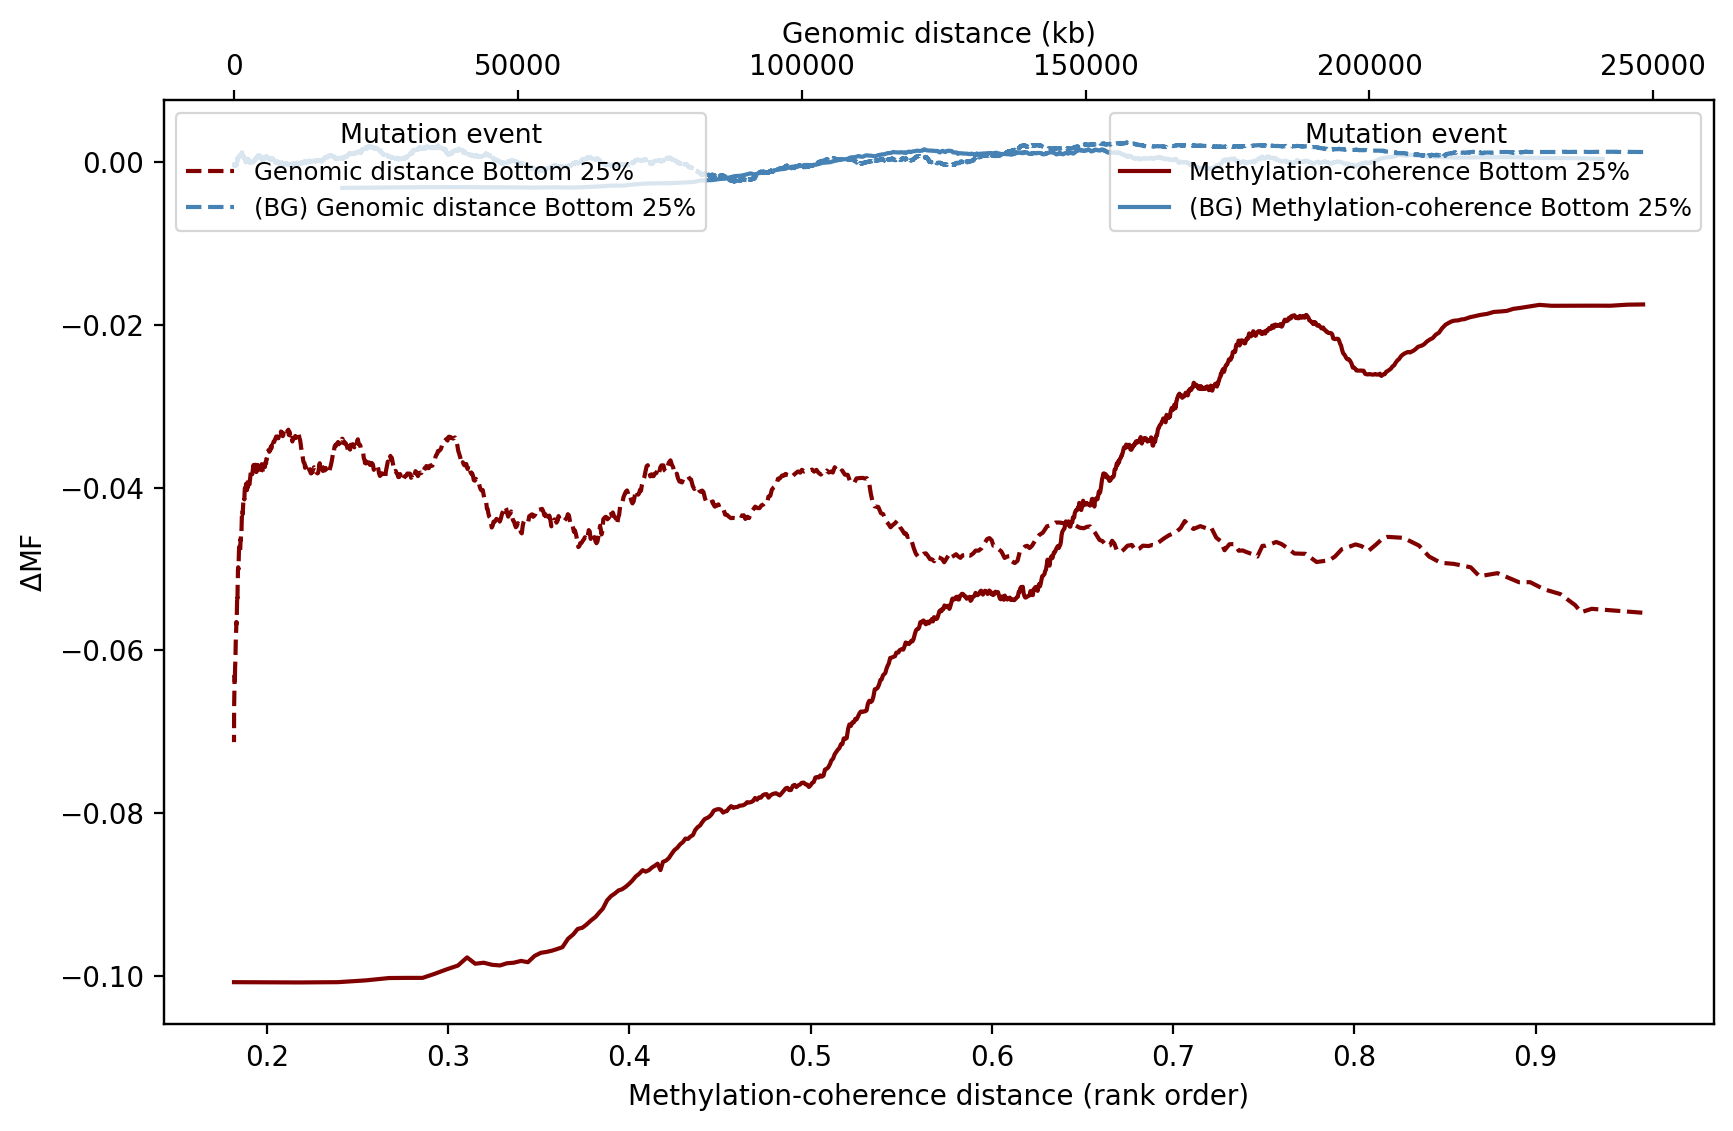

In [12]:
# there are num_top_muts * 1000 rows = 138,000
# and num_top_muts rows for each correlation distance value
# so 10,000 is 
biggest_neg_to_plot_smoothed_corr, biggest_neg_to_plot_smoothed_dist = analyze_comethylation.plot_distance_of_effect_lineplot(
    icgc_corr_mean_metrics_df, icgc_corr_all_metrics_df, num_top_muts = 218, # top 138/873 = 15%
    smoothing_window_size_corr = 10900, # num_top_muts * 50, meaning 50 corr distances are averaged together
    smoothing_window_size_dist = 10900, 
    corr_dist = 'reverse_corr', # corr or measured_site_dist
    dist = 10, plot_bg = True, out_fn = os.path.join(fig_out_dir, 'figure4/figure4E_icgc_distance_of_effect_corr_vs_dist_allTogether_w_background_corrCoef.svg'), corr_vs_dist = True,
    illumina_cpg_locs_df = illumina_cpg_locs_df, rank_order_dist = False
    ) # fig is 10, 6

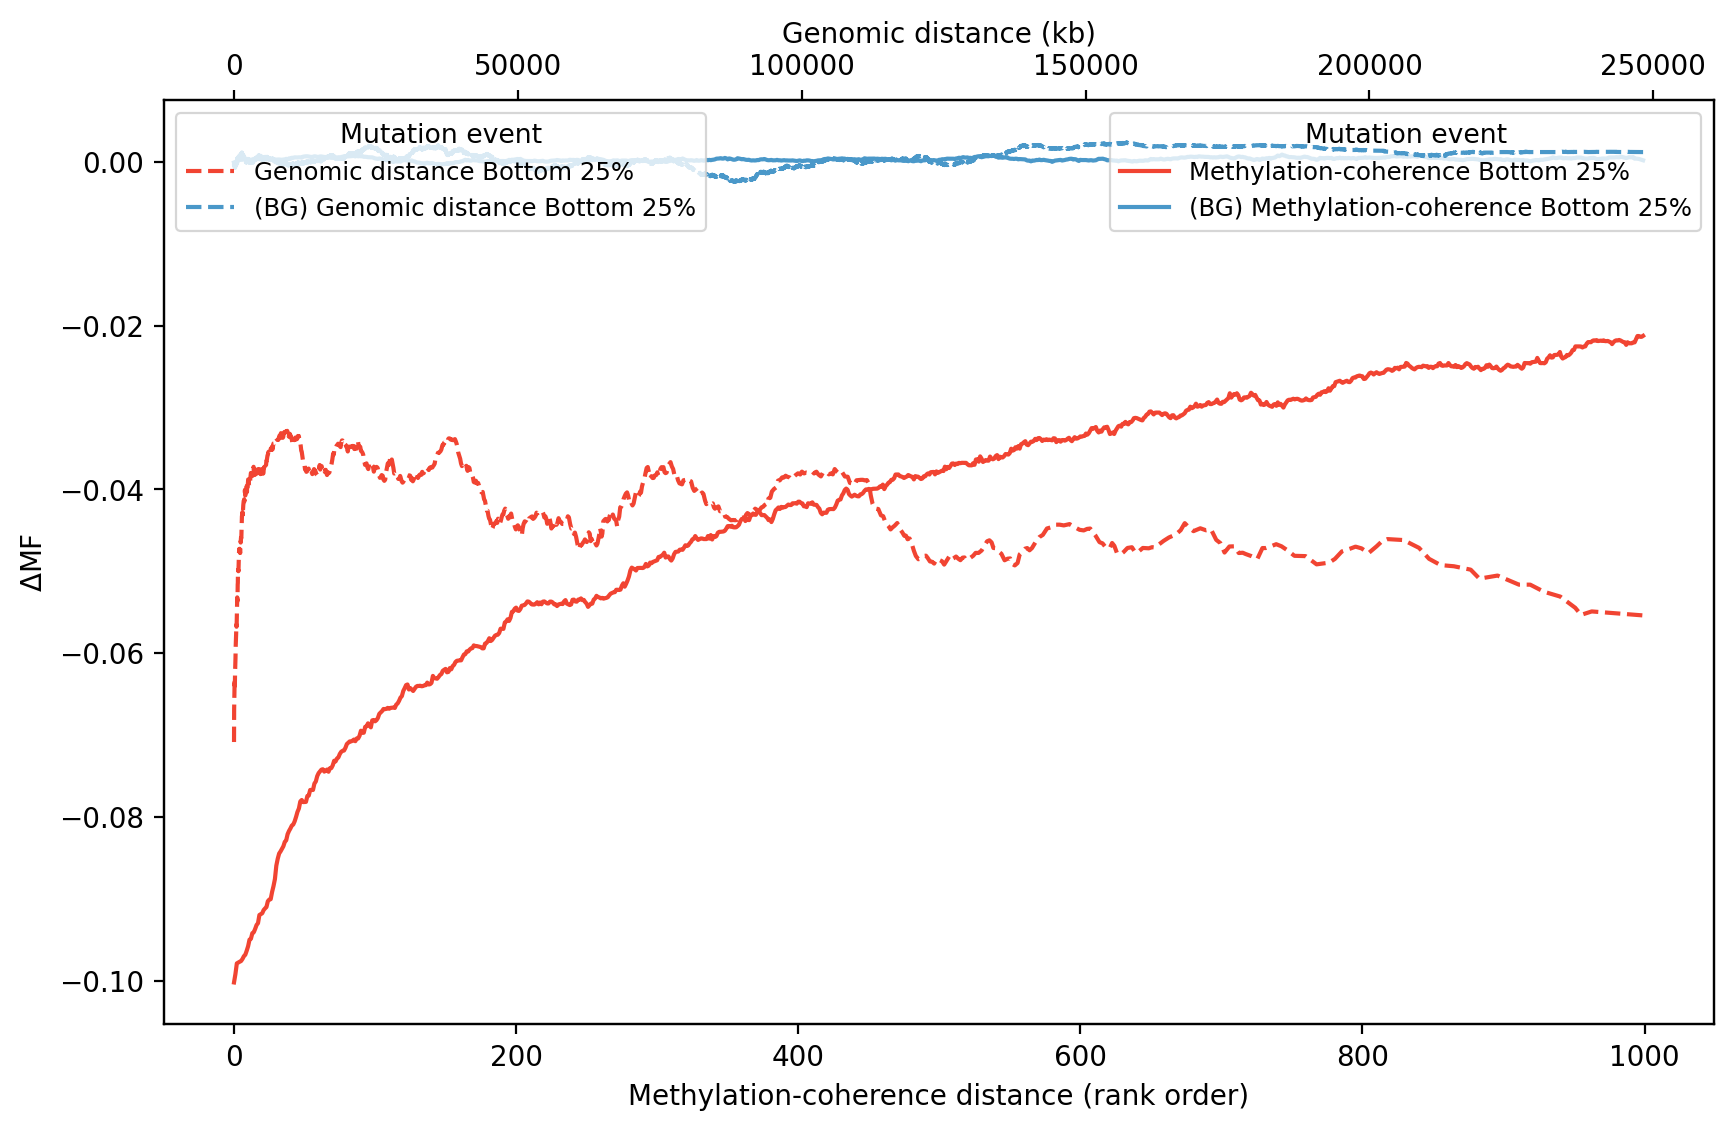

In [10]:
# there are num_top_muts * 1000 rows = 138,000
# and num_top_muts rows for each correlation distance value
# so 10,000 is 
_ = analyze_comethylation.plot_distance_of_effect_lineplot(
    icgc_corr_mean_metrics_df, icgc_corr_all_metrics_df, num_top_muts = 218, # top 138/873 = 15%
    smoothing_window_size_corr = 10900, # num_top_muts * 50, meaning 50 corr distances are averaged together
    smoothing_window_size_dist = 10900, 
    dist = 10, plot_bg = True, out_fn = os.path.join(fig_out_dir, 'figure4/figure4E_icgc_distance_of_effect_corr_vs_dist_allTogether_w_background.svg'), corr_vs_dist = True,
    illumina_cpg_locs_df = illumina_cpg_locs_df, rank_order_dist = False
    ) # fig is 10, 6

In [143]:
dist = 10
num_top_muts = 218
mean_metrics_df = icgc_corr_mean_metrics_df
all_metrics_df = icgc_corr_all_metrics_df

filtered_df = mean_metrics_df.query(
            'distance == @dist & mutated_sample == True & is_background == False'
            )
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
# get the 'mut_event' identifiers for these top events
biggest_neg_effect = sorted_df.loc[neg_indices, 'mut_event'].values
biggest_pos_effect = sorted_df.loc[pos_indices, 'mut_event'].values
# in all_metrics, select these mut events
biggest_neg_to_plot = all_metrics_df.loc[
    all_metrics_df['mutated_sample'] == True
    ].query('mut_event in @biggest_neg_effect or index_event in @biggest_neg_effect')
biggest_pos_to_plot = all_metrics_df.loc[
    all_metrics_df['mutated_sample'] == True
    ].query('mut_event in @biggest_pos_effect or index_event in @biggest_pos_effect')
        

In [144]:
def get_genomic_dist_from_corr(corr_metrics_df, illumina_cpg_locs_df):
    mut_corr_all_metrics_df = corr_metrics_df.copy()
    #mut_corr_all_metrics_df = corr_all_metrics_df.query("is_background == False").copy()
    mut_corr_all_metrics_df.loc[:, 'mut_start'] = mut_corr_all_metrics_df['mut_event'].apply(
        lambda x: int(x.split(':')[-1])
        )
    mut_corr_all_metrics_df = illumina_cpg_locs_df.merge(
        mut_corr_all_metrics_df, left_on='#id', right_on='measured_site', how = 'right'
        )
    mut_corr_all_metrics_df.rename(columns={'start': 'measured_start'}, inplace=True)
    mut_corr_all_metrics_df['genomic_dist'] = mut_corr_all_metrics_df['mut_start'].astype(int) - mut_corr_all_metrics_df['measured_start'].astype(int)
    mut_corr_all_metrics_df['abs_genomic_dist'] = mut_corr_all_metrics_df['genomic_dist'].abs()
    return mut_corr_all_metrics_df
# convet the corr distance to genomic distance
biggest_neg_to_plot_fg = get_genomic_dist_from_corr(
    biggest_neg_to_plot.query("is_background == False"), illumina_cpg_locs_df
    ).drop_duplicates(['measured_site', 'mut_event'])
"""biggest_pos_to_plot_fg = get_genomic_dist_from_corr(
    biggest_pos_to_plot.query("is_background == False"), illumina_cpg_locs_df
    ).drop_duplicates(['measured_site', 'mut_event'])"""
# same for background
biggest_neg_bg_to_plot = get_genomic_dist_from_corr(
    biggest_neg_to_plot.query("is_background == True"), illumina_cpg_locs_df
    )
"""biggest_pos_bg_to_plot = get_genomic_dist_from_corr(
    biggest_pos_to_plot.query("is_background == True"), illumina_cpg_locs_df
    )"""

'biggest_pos_bg_to_plot = get_genomic_dist_from_corr(\n    biggest_pos_to_plot.query("is_background == True"), illumina_cpg_locs_df\n    )'

In [145]:


biggest_to_plot_fg_sorted_by_corr_dist = biggest_neg_to_plot_fg.sort_values(by=['corr'], ascending=False)
biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed = biggest_to_plot_fg_sorted_by_corr_dist.rolling(218, center=False, min_periods=0, closed = 'left').median()
biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed['reverse_dmf'] = 1 - biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed['delta_mf_median']
biggest_neg_to_plot_fg_sorted_by_corr_dist_extra_smoothed = biggest_to_plot_fg_sorted_by_corr_dist.rolling(2180, center=False, min_periods=0, closed = 'right').median()
biggest_neg_to_plot_fg_sorted_by_corr_dist_extra_smoothed['reverse_dmf'] = 1 - biggest_neg_to_plot_fg_sorted_by_corr_dist_extra_smoothed['delta_mf_median']
biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed['abs_delta_mf_median'] = biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed['delta_mf_median'].abs()

biggest_neg_bg_to_plot_sorted_by_corr_dist = biggest_neg_bg_to_plot.sort_values(by=['corr'], ascending=False)
biggest_neg_bg_to_plot_sorted_by_corr_dist_smoothed = biggest_neg_bg_to_plot_sorted_by_corr_dist.rolling(218, center=False, min_periods=0, closed = 'left').median()
biggest_neg_bg_to_plot_sorted_by_corr_dist_smoothed['abs_delta_mf_median'] = biggest_neg_bg_to_plot_sorted_by_corr_dist_smoothed['delta_mf_median'].abs()


Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['#id', 'Strand', 'index_event', 'measured_site', 'mut_event',
       'mut_sample', 'mut_sample_dset'],
      dtype='object')
Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['#id', 'Strand', 'index_event', 'measured_site', 'mut_event',
       'mut_sample', 'mut_sample_dset'],
      dtype='object')


In [200]:
biggest_to_plot_fg_sorted_by_dist = biggest_neg_to_plot_fg.sort_values(by=['abs_genomic_dist'], ascending=False)
biggest_neg_to_plot_fg_sorted_by_dist_smoothed = biggest_to_plot_fg_sorted_by_dist.rolling(218, center=False, min_periods=0, closed = 'left').median()
biggest_neg_to_plot_fg_sorted_by_dist_smoothed['abs_delta_mf_median'] = biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed['delta_mf_median'].abs()

biggest_neg_bg_to_plot_sorted_by_dist = biggest_neg_bg_to_plot.sort_values(by=['abs_genomic_dist'], ascending=False)
biggest_neg_bg_to_plot_sorted_by_dist_smoothed = biggest_neg_bg_to_plot_sorted_by_dist.rolling(218, center=False, min_periods=0, closed = 'left').median()
biggest_neg_bg_to_plot_sorted_by_dist_smoothed['abs_delta_mf_median'] = biggest_neg_bg_to_plot_sorted_by_dist_smoothed['delta_mf_median'].abs()


Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['#id', 'Strand', 'binned_abs_genomic_dist', 'binned_corr',
       'binned_reverse_corr', 'index_event', 'measured_site', 'mut_event',
       'mut_sample', 'mut_sample_dset'],
      dtype='object')


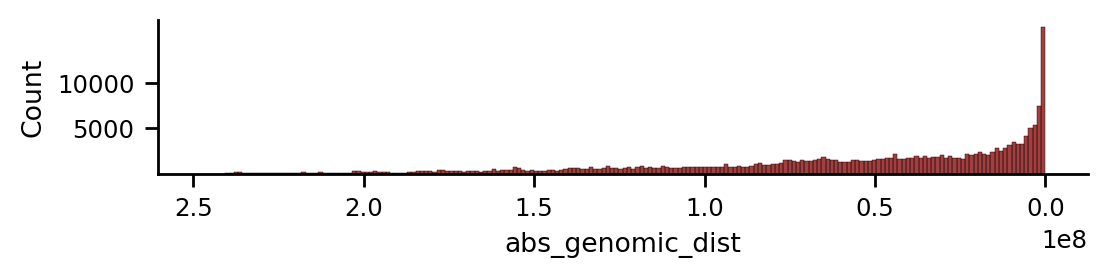

In [116]:
sns.set_context('paper', font_scale=1)
fig, axes = plt.subplots(figsize=(6, 1))
sns.histplot(data = biggest_neg_to_plot_fg, x = 'abs_genomic_dist', bins = 200, ax = axes, color='maroon')
# reverse x axis order
axes.set_xlim(axes.get_xlim()[::-1])
sns.despine()
# set x ticks at 5000 and 10000
axes.set_yticks([5000, 10000])
#plt.savefig(os.path.join(fig_out_dir, 'figure4/figure4E_y1.svg'), dpi = 300, format = 'svg')


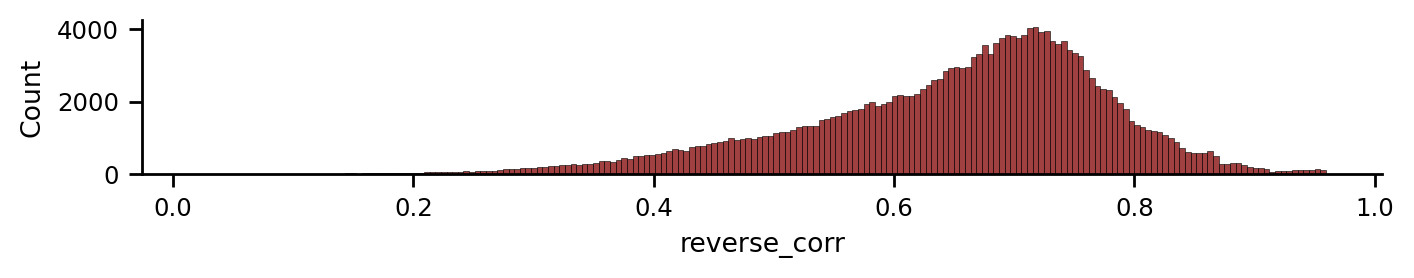

In [110]:
sns.set_context('paper', font_scale=1)
fig, axes = plt.subplots(figsize=(8, 1))
sns.histplot(data = biggest_neg_to_plot_fg, x = 'reverse_corr', bins = 200, ax = axes, color='maroon')
sns.despine()
#plt.savefig(os.path.join(fig_out_dir, 'figure4/figure4E_x1.svg'), dpi = 300, format = 'svg')


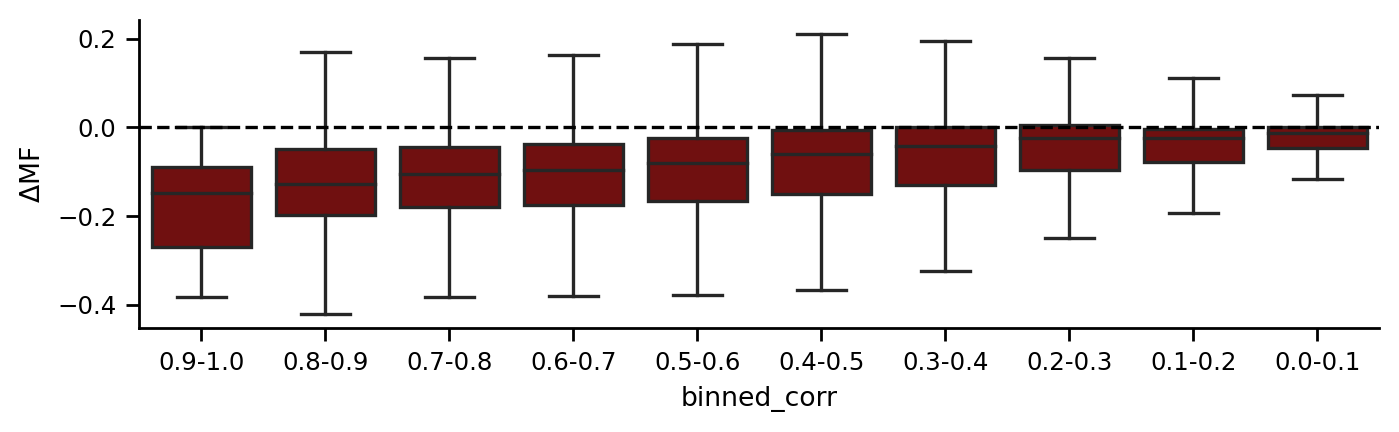

In [286]:
sns.set_context('paper', font_scale=1)
fig, axes = plt.subplots(figsize=(8, 2))
biggest_neg_to_plot_fg['binned_corr'] = pd.cut(biggest_neg_to_plot_fg['corr'], bins= np.linspace(0, 1, 11), labels = [f'{i/10}-{(i+1)/10}' for i in range(10)])
sns.boxplot(data = biggest_neg_to_plot_fg, x = 'binned_corr', y = 'delta_mf_median', ax = axes, color='maroon', showfliers=False)
axes.axhline(y=0, linestyle='--', color='black')
axes.set_xlim(axes.get_xlim()[::-1])
# reverse x axis order
sns.despine()
plt.ylabel(r'$\Delta$MF')
plt.savefig(os.path.join(fig_out_dir, 'figure4/figure4E_dmf_vs_corr.svg'), dpi = 300, format = 'svg')


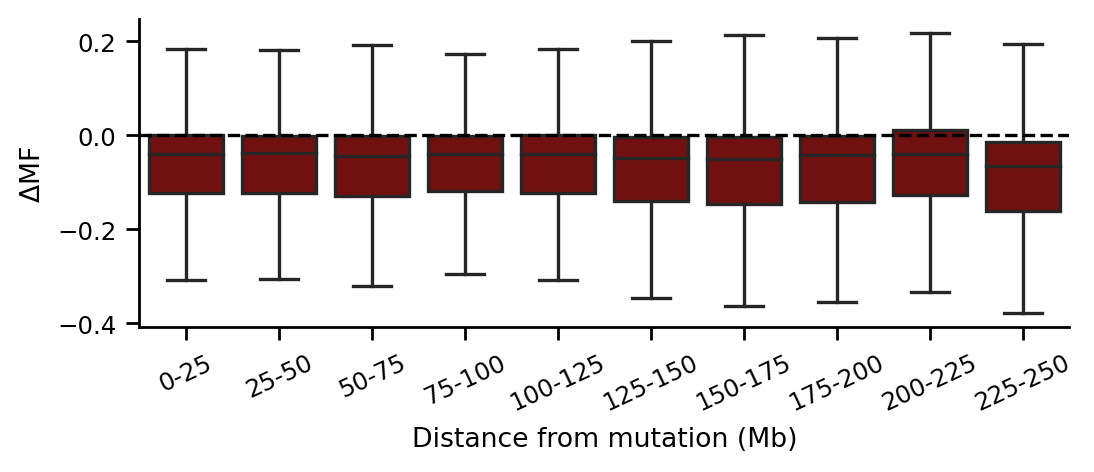

In [285]:
sns.set_context('paper', font_scale=1)
fig, axes = plt.subplots(figsize=(6, 2))
biggest_neg_to_plot_fg['binned_abs_genomic_dist'] = pd.cut(biggest_neg_to_plot_fg['abs_genomic_dist']/1e6, bins=np.linspace(0,250,11 ), labels =[f'{i}-{(i+25)}' for i in range(0, 250, 25)])
sns.boxplot(data = biggest_neg_to_plot_fg, x = 'binned_abs_genomic_dist', y = 'delta_mf_median', ax = axes, color='maroon',showfliers=False)
# put x labels in scientific notation
# reverse x axis order
# show every other x tick label
sns.despine()
axes.axhline(y=0, linestyle='--', color='black')
# angle x tick labels
_ = axes.set_xticklabels(axes.get_xticklabels(), rotation=25, ha='center')
plt.xlabel('Distance from mutation (Mb)')
plt.ylabel(r'$\Delta$MF')
plt.savefig(os.path.join(fig_out_dir, 'figure4/figure4E_dmf_vs_dist.svg'), dpi = 300, format = 'svg')


In [252]:

fg_corr = biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')
fg_corr_close = biggest_neg_to_plot_fg_sorted_by_corr_dist_smoothed.query("abs_genomic_dist < 15000")[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')
fg_dist = biggest_neg_to_plot_fg_sorted_by_dist_smoothed[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')
fg_dist_close = biggest_neg_to_plot_fg_sorted_by_dist_smoothed.query("abs_genomic_dist < 15000")[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')
bg_corr = biggest_neg_bg_to_plot_sorted_by_corr_dist_smoothed[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')
bg_corr_close = biggest_neg_bg_to_plot_sorted_by_corr_dist_smoothed.query("abs_genomic_dist < 15000")[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')
bg_dist = biggest_neg_bg_to_plot_sorted_by_dist_smoothed[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')
bg_dist_close = biggest_neg_bg_to_plot_sorted_by_dist_smoothed.query("abs_genomic_dist < 15000")[['delta_mf_median', 'abs_delta_mf_median', 'corr','abs_genomic_dist']].corr(method = 'spearman')

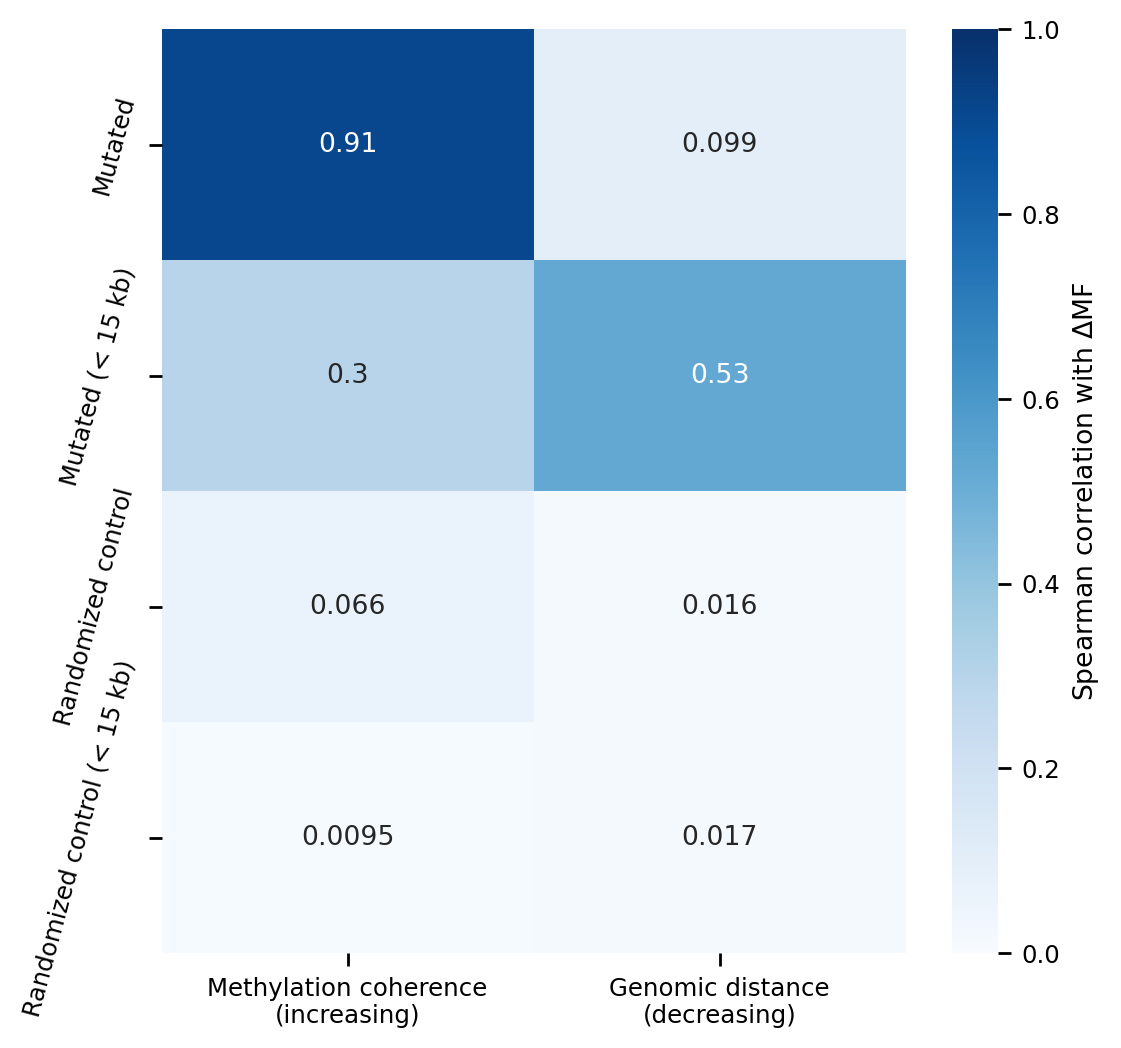

In [284]:
sns.set_context('paper', font_scale=1)
fig, axes = plt.subplots(figsize=(6, 6))
corr_df = pd.concat([fg_corr.loc['delta_mf_median'], fg_corr_close.loc['delta_mf_median'], fg_dist.loc['delta_mf_median'], fg_dist_close.loc['delta_mf_median'], bg_corr.loc['delta_mf_median'], bg_corr_close.loc['delta_mf_median'], bg_dist.loc['delta_mf_median'], bg_dist_close.loc['delta_mf_median']], axis=1)
corr_df.columns = ['corr', 'corr_close', 'dist', 'dist_close', 'bg_corr', 'bg_corr_close', 'bg_dist', 'bg_dist_close']
corr_df = corr_df.T
sns.heatmap(corr_df.loc[['corr', 'dist_close', 'bg_corr', 'bg_dist_close'], ['corr', 'abs_genomic_dist']].abs(), annot=True, cmap='Blues', center=0.5, ax = axes, vmin=0, vmax=1, cbar_kws={'label': r'Spearman correlation with $\Delta$MF'})
# set x tick labels
axes.set_xticklabels(['Methylation coherence\n(increasing)', 'Genomic distance\n(decreasing)'])
# set y tick labels 
_ = axes.set_yticklabels(['Mutated', 'Mutated (< 15 kb)', 'Randomized control', 'Randomized control (< 15 kb)'], rotation=75, ha='right')
plt.savefig(os.path.join(fig_out_dir, 'figure4/figure4E_corr_vs_dist_heatmap_spearman.svg'), dpi = 300, format = 'svg')

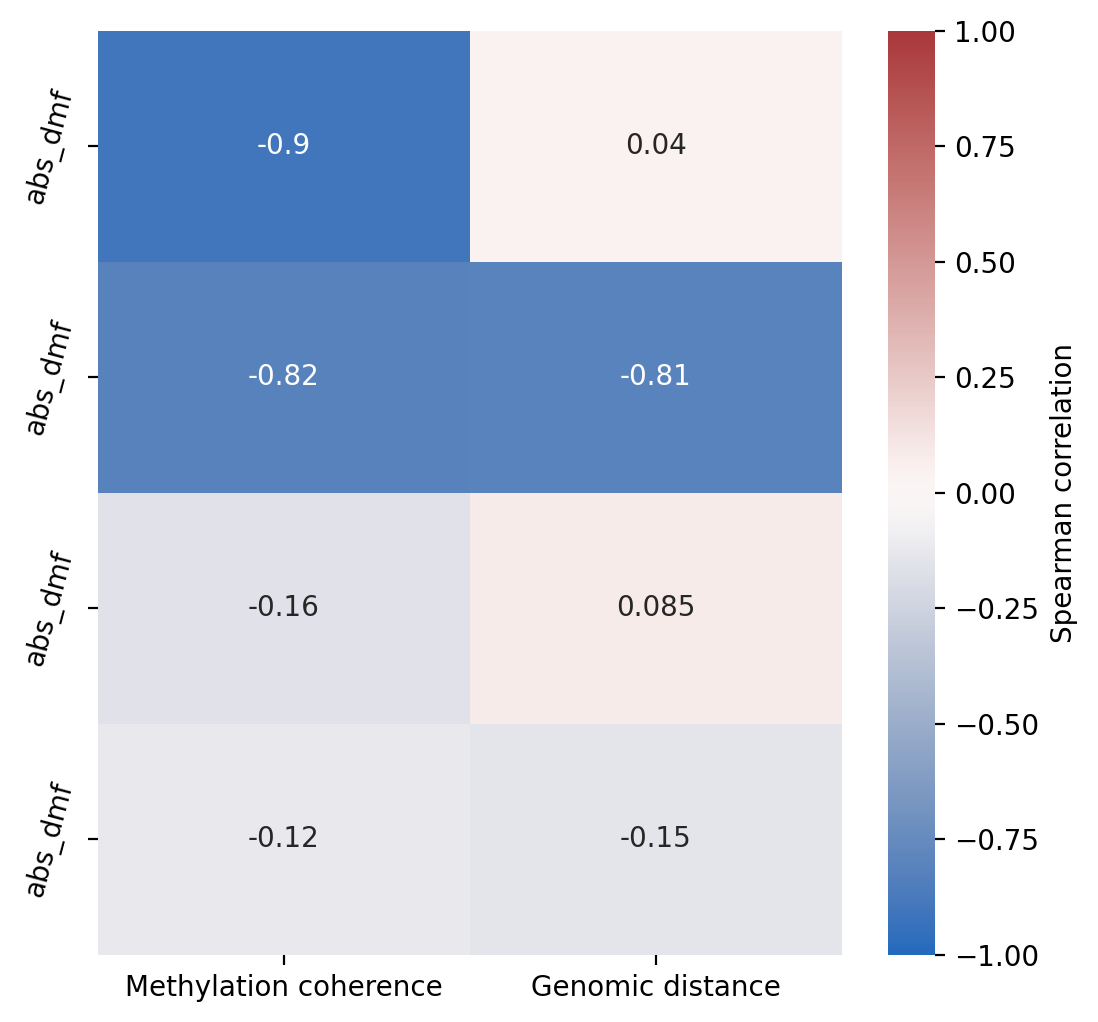

In [111]:
fig, axes = plt.subplots(figsize=(6, 6))
# add black border
sns.heatmap(pd.concat([fg_corr.loc['abs_delta_mf_median'], fg_corr_close.loc['abs_delta_mf_median'],fg_dist bg_corr.loc['abs_delta_mf_median'], bg_corr_close.loc['abs_delta_mf_median']], axis=1).T[['Methylation coherence', 'Genomic distance']], cmap='vlag', annot=True, vmin=-1, vmax=1,ax = axes, cbar_kws={'label': 'Spearman correlation'})
# angle yticklabels
plt.yticks(rotation=75)
plt.savefig(os.path.join(fig_out_dir, 'figure4/abs_dmf_corr_with_distances.svg'), dpi = 300, format = 'svg')

# Gene-set enrichment for CpG modules

#### TCGA

In [4]:
def load_annot_files(annot_results_dir: str, Ns: list):
    result_dfs = []
    # create default 
    result_cpg_mods = defaultdict(dict)
    for N in Ns:
        # same but for corr
        corr_annot_results_df = pd.read_parquet(os.path.join(annot_results_dir, f"1000cpgs_{N}corr_cpgs_100000min_dist", 'annot_results_df.parquet'))
        corr_annot_results_df['N'] = N
        corr_annot_results_df['type'] = 'Corr'
        corr_cpgs_in_modules = pd.read_json(os.path.join(annot_results_dir, f"1000cpgs_{N}corr_cpgs_100000min_dist", 'cpg_modules_correlation.json'))
        # same but for close
        close_annot_results_df = pd.read_parquet(os.path.join(annot_results_dir, f"1000cpgs_{N}corr_cpgs_100000min_dist", 'close_annot_results_df.parquet'))
        close_annot_results_df['N'] = N
        close_annot_results_df['type'] = 'Close'
        close_cpgs_in_modules = pd.read_json(os.path.join(annot_results_dir, f"1000cpgs_{N}corr_cpgs_100000min_dist", 'cpg_modules_close.json'))
        # same but for random
        random_annot_results_df = pd.read_parquet(os.path.join(annot_results_dir, f"1000cpgs_{N}corr_cpgs_100000min_dist", 'random_annot_results_df.parquet'))
        random_annot_results_df['N'] = N
        random_annot_results_df['type'] = 'Random'
        random_cpgs_in_modules = pd.read_json(os.path.join(annot_results_dir, f"1000cpgs_{N}corr_cpgs_100000min_dist", 'cpg_modules_random.json'))
        # append to lists
        result_dfs.append(corr_annot_results_df)
        result_dfs.append(close_annot_results_df)
        result_dfs.append(random_annot_results_df)
        # add to dict 
        result_cpg_mods[N]['Corr'] = corr_cpgs_in_modules
        result_cpg_mods[N]['Close'] = close_cpgs_in_modules
        result_cpg_mods[N]['Random'] = random_cpgs_in_modules
    # create one result df 
    result_df = pd.concat(result_dfs)
    
    return result_df, result_cpg_mods

In [55]:
annot_results_df, result_cpg_mods = load_annot_files(
    annot_results_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071723_cpg_module_annot_output", Ns = [250, 500, 1000]
    )

In [6]:
chr1_dist_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/dependency_files/all_distances_chrom1_PANCAN.parquet')

In [56]:

# for each result_cpg_mods, convert to distances
Ns = [250, 500, 1000]
types = ['Corr', 'Close', 'Random']
result_cpg_mod_dists_l = []
for N in Ns:
    for t in types:
        result_cpg_mod_dists = result_cpg_mods[N][t].apply(
            lambda x: chr1_dist_df.loc[x.name, x.values].reset_index(drop=True), axis = 0
            ).melt(var_name = 'CpG', value_name = 'Distance')
        result_cpg_mod_dists['N'] = N
        result_cpg_mod_dists['Type'] = t
        result_cpg_mod_dists_l.append(result_cpg_mod_dists)
result_cpg_mod_dists_df = pd.concat(result_cpg_mod_dists_l)
result_cpg_mod_dists_df['Type'] = result_cpg_mod_dists_df['Type'].map({'Corr': 'Epigenetic distance', 'Close': 'Genomic distance', 'Random': 'Random'})
result_cpg_mod_dists_df['log_distance'] = np.log10(result_cpg_mod_dists_df['Distance'])
result_cpg_mod_dists_df['Distance (Mb)'] = result_cpg_mod_dists_df['Distance'] / 1e6

In [62]:
number_significant_cpgs = annot_results_df.groupby(['N', 'type'])['cpg_name'].nunique().reset_index()
number_significant_cpgs.rename(columns = {'cpg_name': 'Number of significant CpGs'}, inplace = True)
number_significant_cpgs['prop_sig']  = number_significant_cpgs['Number of significant CpGs'] / 1000
number_significant_cpgs['type'] = number_significant_cpgs['type'].map({'Corr': 'Epigenetic distance', 'Close': 'Genomic distance', 'Random': 'Random'})


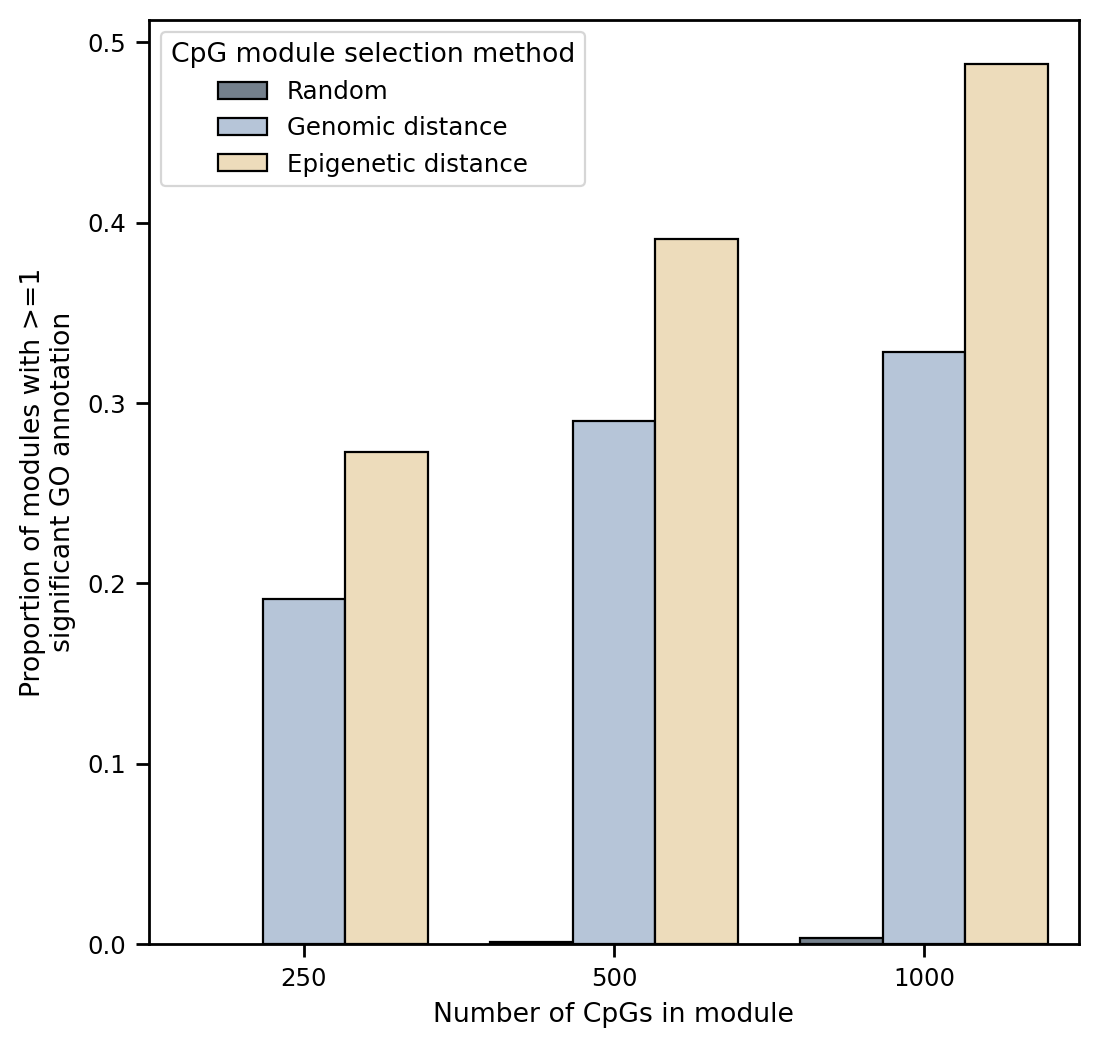

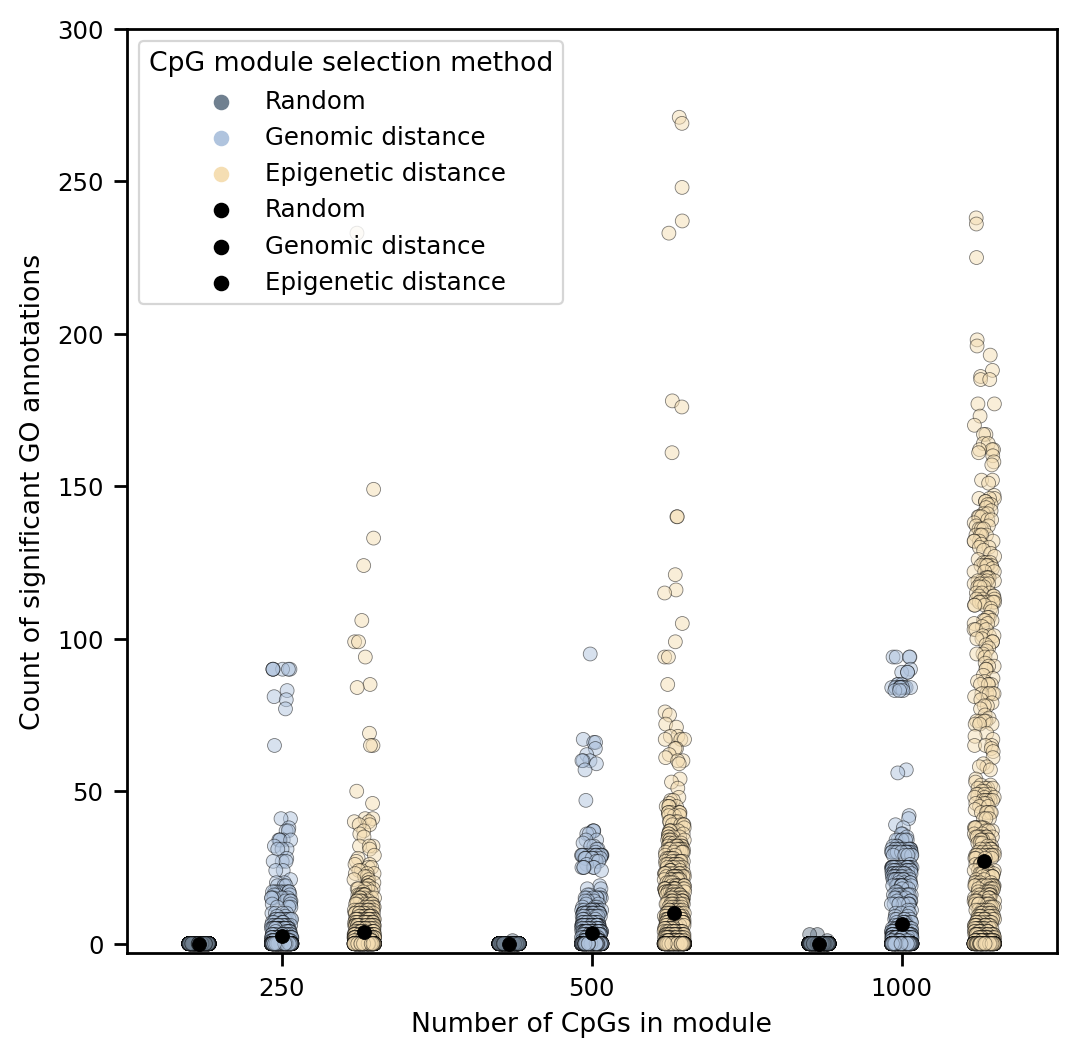

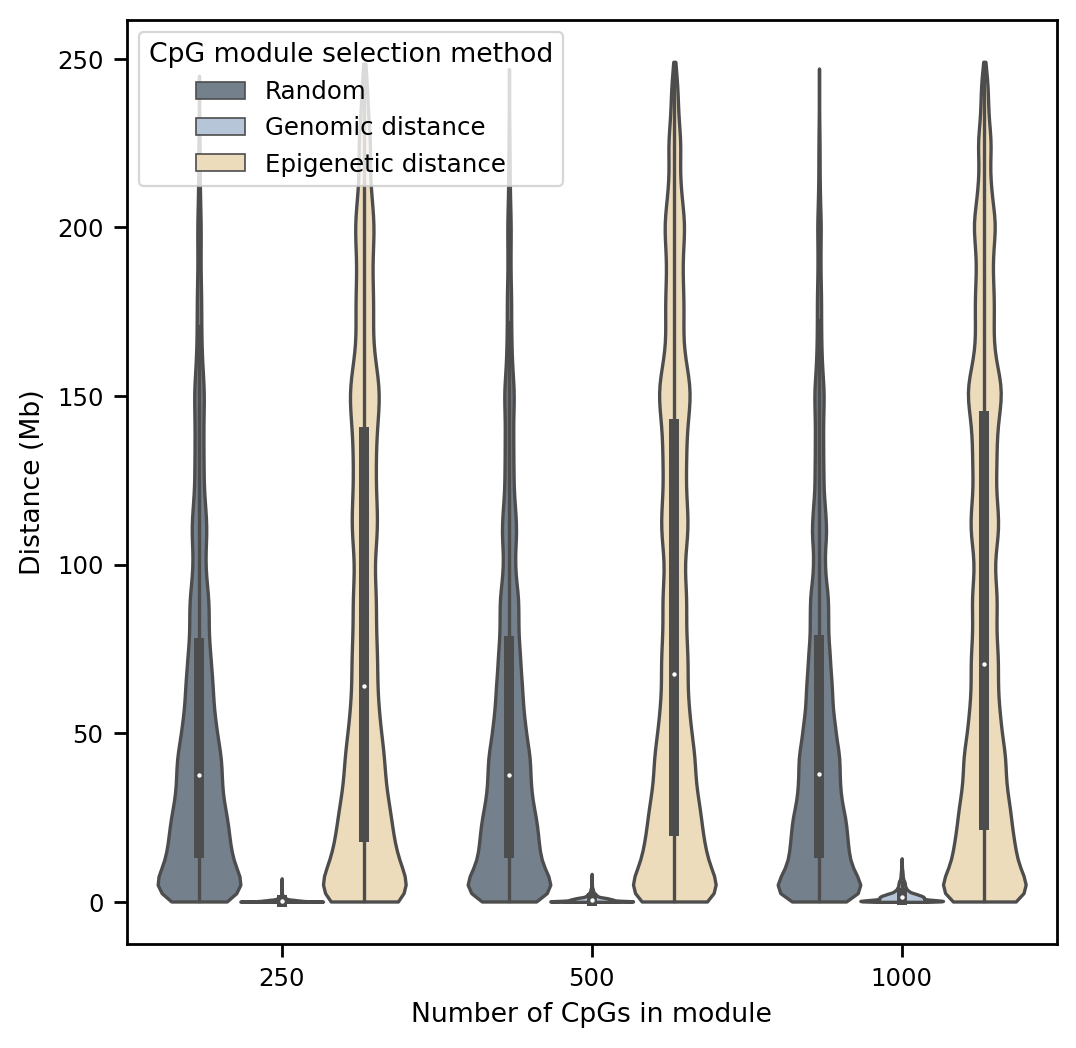

In [125]:
number_significant_cpgs = annot_results_df.groupby(['N', 'type'])['cpg_name'].nunique().reset_index()
number_significant_cpgs.rename(columns = {'cpg_name': 'Number of significant CpGs'}, inplace = True)
number_significant_cpgs['prop_sig']  = number_significant_cpgs['Number of significant CpGs'] / 1000
number_significant_cpgs['type'] = number_significant_cpgs['type'].map({'Corr': 'Epigenetic distance', 'Close': 'Genomic distance', 'Random': 'Random'})

sns.set_context('paper')
# make right plot bigger
# others are 8x6 and 10x6, so make this one 20
fig, axes = plt.subplots(1,1, figsize = (6, 6))#, gridspec_kw={'width_ratios': [1, 1.5, ]})
sns.barplot(
    data = number_significant_cpgs, x = 'N', y = 'prop_sig', hue = 'type', hue_order=['Random', 'Genomic distance', 'Epigenetic distance'], palette=['slategray', 'lightsteelblue', 'wheat'], edgecolor = 'black', ax = axes
    )
axes.set_ylabel('Proportion of modules with >=1\nsignificant GO annotation')
axes.set_xlabel('Number of CpGs in module')

# set legend title
axes.legend(title = 'CpG module selection method', loc = 'upper left')
# turn off legend
#axes.legend().set_visible(False)
plt.savefig("/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure4/figure4b_num_sig_cpgs.svg", format = 'svg', dpi = 300)


fig, axes = plt.subplots(1,1, figsize = (6, 6))#, gridspec_kw={'width_ratios': [1, 1.5, ]})

number_significant_annots = annot_results_df.groupby(['N', 'type'])['cpg_name'].value_counts().reset_index(name = 'Count of significant GO annotations')
number_significant_annots['type'] = number_significant_annots['type'].map({'Corr': 'Epigenetic distance', 'Close': 'Genomic distance', 'Random': 'Random'})


# for each type, add in 0s
type_counts = number_significant_annots[['type', 'N']].value_counts().reset_index(name = 'Count of this type')
type_counts['Number to add'] = 1000 - type_counts['Count of this type']
row_to_add = ['Random', 250, 0, 1000]
type_counts.loc[type_counts.shape[0]] = row_to_add
all_rows_to_add = []
for i, row in type_counts.iterrows():
    if row['Number to add'] > 0:
        for j in range(row['Number to add']):
            all_rows_to_add.append([row['N'], row['type'], np.nan, 0])
all_rows_to_add_df = pd.DataFrame(all_rows_to_add, columns = ['N', 'type', 'cpg_name', 'Count of significant GO annotations'])
number_significant_annots = pd.concat([number_significant_annots, all_rows_to_add_df])
sns.stripplot(
    data = number_significant_annots, x = 'N',  y = 'Count of significant GO annotations', hue = 'type', hue_order=['Random', 'Genomic distance', 'Epigenetic distance'], palette=['slategray', 'lightsteelblue', 'wheat'], edgecolor = 'black', dodge = True, alpha = .5, linewidth = .3, ax = axes
    )
# add a dot at median of each type
mean_data = number_significant_annots.groupby(['N', 'type'])['Count of significant GO annotations'].mean().reset_index()
sns.stripplot(
    data = mean_data, x = 'N',  y = 'Count of significant GO annotations', hue = 'type', hue_order=['Random', 'Genomic distance', 'Epigenetic distance'], palette=['black', 'black', 'black'], edgecolor = 'black', dodge = True, alpha = 1, linewidth = .3, ax = axes, jitter = 2
    )
# set top of y axis to 300
axes.set_ylim(-3, 300)
#plt.ylabel('Proportion of CpGs with >=1\nsignificant GO annotation')
axes.set_xlabel('Number of CpGs in module')
# set legend title
axes.legend(title = 'CpG module selection method', loc = 'upper left')
plt.savefig("/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure4/figure4c_num_sig_go.svg", format = 'svg', dpi = 300)


fig, axes = plt.subplots(1,1, figsize = (6, 6))#, gridspec_kw={'width_ratios': [1, 1.5, ]})

sns.violinplot(
    data = result_cpg_mod_dists_df, x = 'N', y = 'Distance (Mb)', hue= 'Type', 
    hue_order=['Random', 'Genomic distance', 'Epigenetic distance'], palette=['slategray', 'lightsteelblue', 'wheat'],
    scale_hue = False, scale = 'width', cut = 0, ax = axes
    )
axes.set_xlabel('Number of CpGs in module')
axes.legend(title = 'CpG module selection method', loc = 'upper left')
plt.savefig("/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure4/figure4d_distances_of_modules.svg", format = 'svg', dpi = 300)

In [102]:
# significance tests for Count of significant GO annotations

# paired mann whitney u tests
from scipy.stats import mannwhitneyu
for n in [250, 500, 1000]:
    print(n)
    # close vs corr
    print("Genomic distance vs Epigenetic distance", mannwhitneyu(
        number_significant_annots.query("type == 'Genomic distance' and N == @n")['Count of significant GO annotations'].values, 
        number_significant_annots.query("type == 'Epigenetic distance' and N == @n")['Count of significant GO annotations'].values
        ))
    print("random vs Genomic distance", mannwhitneyu(
        number_significant_annots.query("type == 'Random' and N == @n")['Count of significant GO annotations'], 
        number_significant_annots.query("type == 'Genomic distance' and N == @n")['Count of significant GO annotations']
        ))
    # random vs corr
    print("random vs Epigenetic distance", mannwhitneyu(
        number_significant_annots.query("type == 'Random' and N == @n")['Count of significant GO annotations'], 
        number_significant_annots.query("type == 'Epigenetic distance' and N == @n")['Count of significant GO annotations']
        ))


250
Genomic distance vs Epigenetic distance MannwhitneyuResult(statistic=457394.5, pvalue=8.148437910708784e-06)
random vs Genomic distance MannwhitneyuResult(statistic=404500.0, pvalue=1.1475915273720426e-47)
random vs Epigenetic distance MannwhitneyuResult(statistic=363500.0, pvalue=3.3289261775695174e-70)
500
Genomic distance vs Epigenetic distance MannwhitneyuResult(statistic=430839.0, pvalue=2.261554952427632e-10)
random vs Genomic distance MannwhitneyuResult(statistic=355370.5, pvalue=1.5968806445772925e-74)
random vs Epigenetic distance MannwhitneyuResult(statistic=304815.5, pvalue=1.842537726820913e-105)
1000
Genomic distance vs Epigenetic distance MannwhitneyuResult(statistic=389034.5, pvalue=4.768801135976002e-22)
random vs Genomic distance MannwhitneyuResult(statistic=337163.5, pvalue=1.4783535867265277e-84)
random vs Epigenetic distance MannwhitneyuResult(statistic=256890.0, pvalue=3.9080686664991987e-137)


In [145]:
8.148437910708784e-6 / 9

9.053819900787538e-07

# Supplemental versions: TCGA D and E

### Disturbance by functional region

<Axes: >

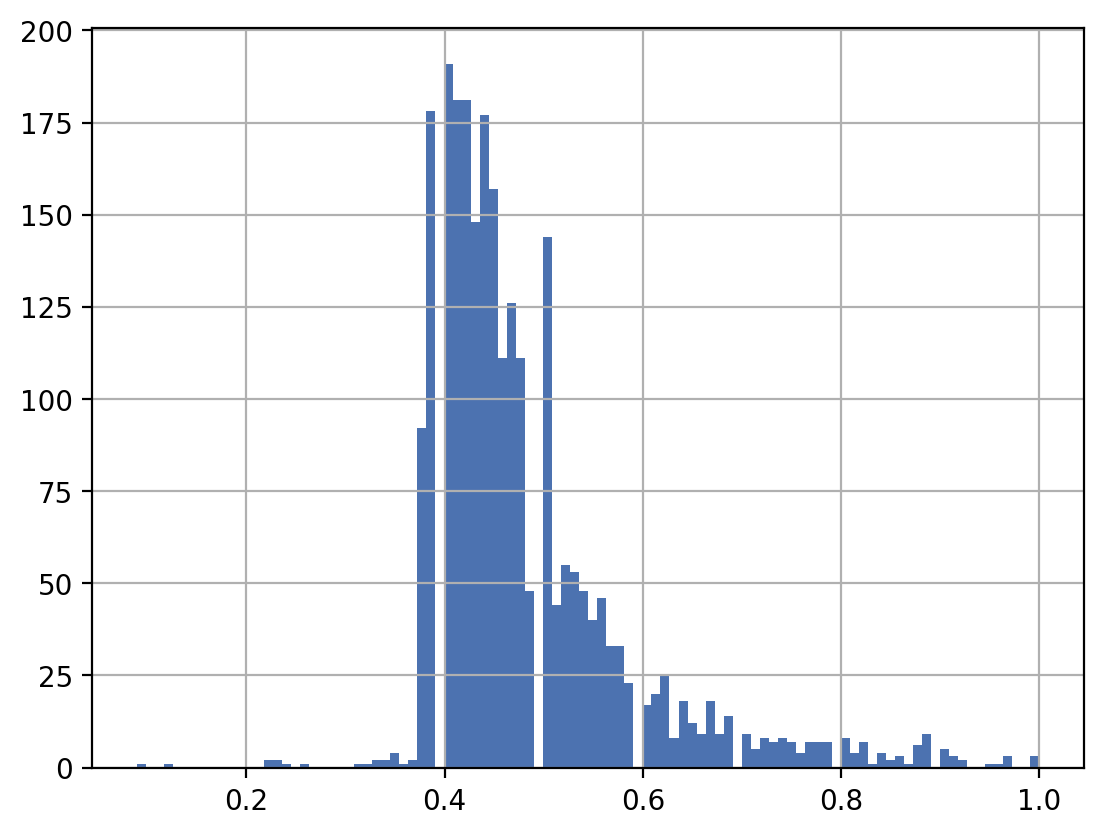

In [9]:
tcga_corr_mean_metrics_w_annot_df['DNA_VAF'].hist(bins = 100)

In [12]:
tcga_corr_mean_metrics_w_annot_df.query("DNA_VAF > .5 or is_background == True")

,mut_event,sample,mean_dmf,mean_abs_dmf,median_dmf,median_abs_dmf,distance,weighted_mean_dmf,log_weighted_mean_dmf,is_background,...,PolyPhen,mut_type,mut_type_combined,seq,was_cpg,new_seq,becomes_cpg,is_cgi,seq_200bp,gc_perc_200bp
0,TCGA-06-0125_10:3375057,TCGA-06-0125,-0.023732,0.062458,0.004993,0.021822,10,NaN,NaN,True,...,None,None,None,CCG,True,CZG,False,False,GCAGGCAAAGATGTGTGTTTTTAAATTCTTAATATGTCTCTACGTC...,0.485
1,TCGA-06-0125_11:20140445,TCGA-06-0125,0.037068,0.065724,0.001511,0.040477,10,NaN,NaN,True,...,None,None,None,CCG,True,CZG,False,False,GCTTTGGTCACGTTCAACGCACTACAGAGCTACGACACAGGGAAAC...,0.470
2,TCGA-06-0125_11:60389679,TCGA-06-0125,0.004604,0.027196,0.000883,0.029000,10,NaN,NaN,True,...,None,None,None,GCG,True,GZG,False,False,gaccccgtctgggaggtgaggagcgtctctgcctggccgccccatc...,0.735
3,TCGA-06-0125_12:130621615,TCGA-06-0125,0.070791,0.094190,0.071226,0.108664,10,NaN,NaN,True,...,None,None,None,TCG,True,TZG,False,False,CTCTGCATGAACTGAAATGATGGCGGGCTCTGCAGGGACAGTTCGC...,0.510
4,TCGA-06-0125_12:133172779,TCGA-06-0125,-0.101003,0.113264,-0.096164,0.096164,10,NaN,NaN,True,...,None,None,None,TCG,True,TZG,False,False,CTGGCATCATCCTCTCCAGAGCCTCTCGTGTTCTCTGACACAGCAG...,0.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251755,TCGA-XF-AAMG_8:103794922,TCGA-XF-AAMG,0.084829,0.094943,0.036968,0.055179,10,NaN,NaN,True,...,None,None,None,ccG,True,cZG,False,False,caccaccagggatccctatttgatcggtacaggtagctgagcactg...,0.570
251756,TCGA-XF-AAMG_9:108418916,TCGA-XF-AAMG,-0.095046,0.095629,-0.065891,0.065891,10,NaN,NaN,True,...,None,None,None,CCG,True,CZG,False,True,GCGTCGCTTTTATGCGTGATGCCGGGGACCCCCTTGTACCGCTCTC...,0.580
251757,TCGA-XF-AAMG_9:112810954,TCGA-XF-AAMG,-0.104849,0.112147,-0.064667,0.064667,10,NaN,NaN,True,...,None,None,None,GCG,True,GZG,False,True,AGGGGCGGTCCGTGGGCGCTGGGCTACTGGAGGGGAAGCGAGGAGG...,0.780
251758,TCGA-XF-AAMG_9:13323130,TCGA-XF-AAMG,-0.303832,0.303832,-0.282951,0.282951,10,NaN,NaN,True,...,None,None,None,TCG,True,TZG,False,True,GTCCATGGCAAGGTCTGCGGGGGCCTCTGCTGTAGCACTGGAGTGG...,0.525


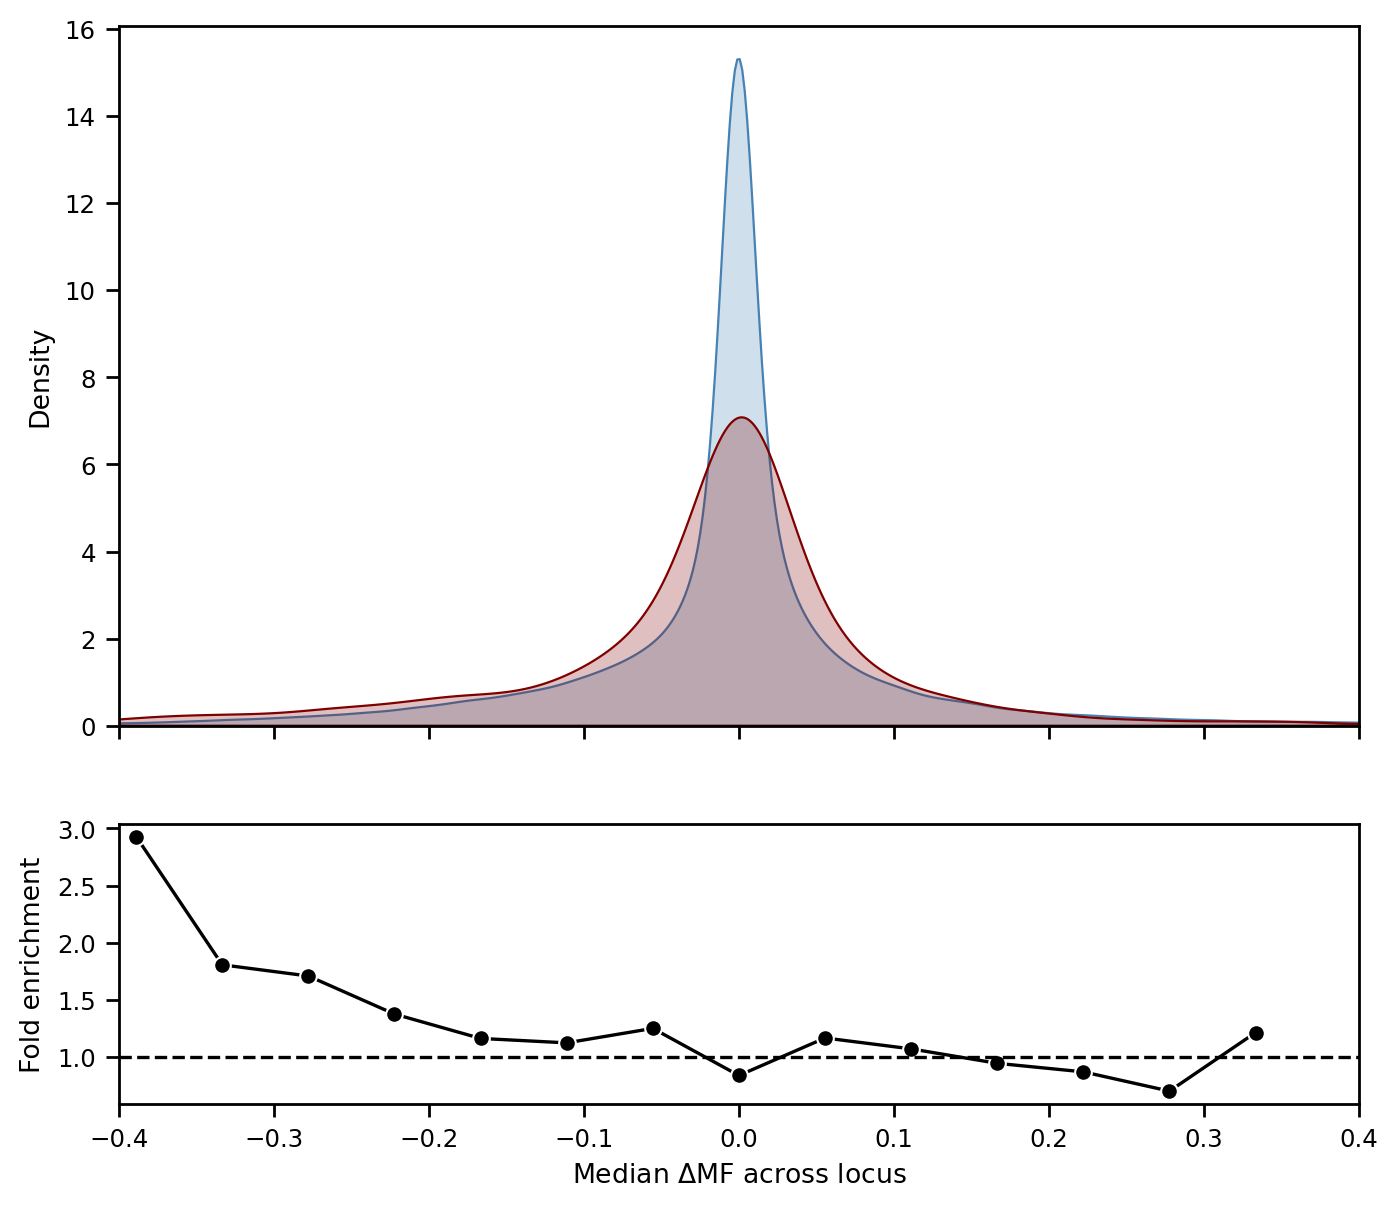

In [15]:
# make second axes bigger kw
fig, axes = plt.subplots(2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True)
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    tcga_corr_mean_metrics_w_annot_df.query("DNA_VAF > .3 or is_background == True"),
    metric = 'median_dmf', axes = axes,
    consortium = 'TCGA', out_fn = os.path.join('./test.svg')
    )

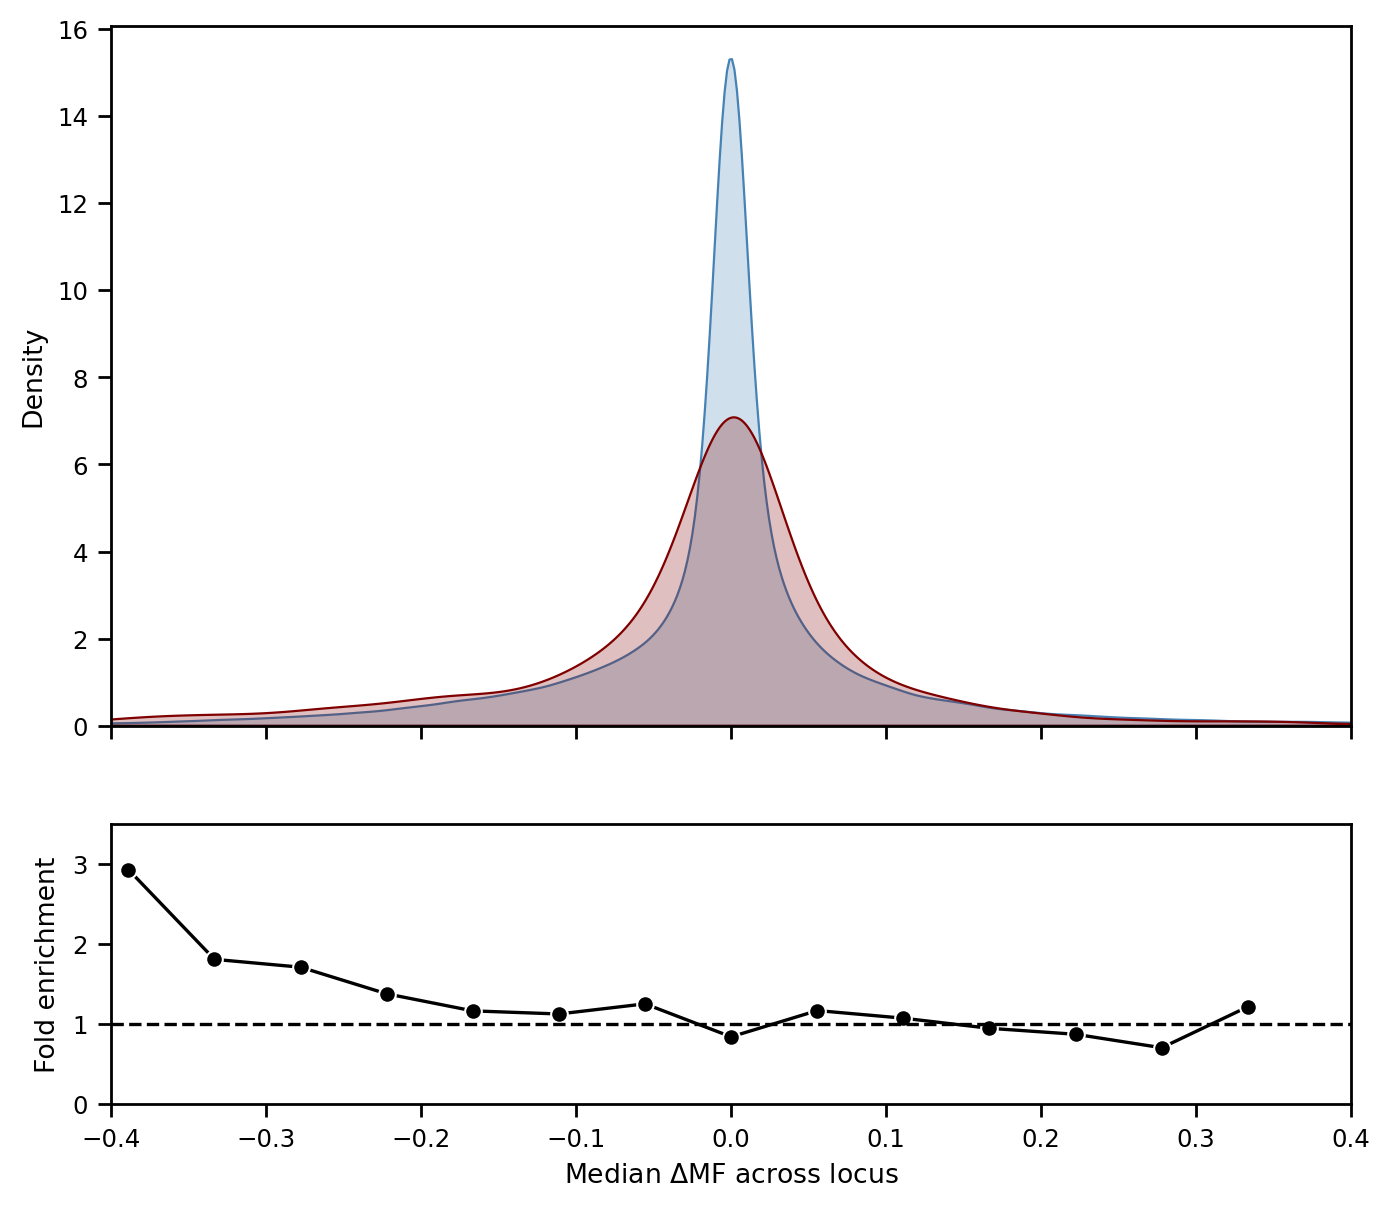

In [19]:
# make second axes bigger kw
fig, axes = plt.subplots(2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True)
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    corr_mean_metrics_df.query("distance == 10"),
    metric = 'median_dmf', axes = axes,
    consortium = 'TCGA', out_fn = os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_figure4D_tcga_median_dmf_kdeplot.pdf')
    )

In [17]:
from scipy.stats import mannwhitneyu
mannwhitneyu(tcga_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 and is_background == False and mutated_sample == True and distance == 10")['median_dmf'], tcga_corr_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10")['median_dmf'])

MannwhitneyuResult(statistic=298639481.0, pvalue=0.0023564895697498877)

In [19]:
mannwhitneyu(tcga_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 and is_background == False and mutated_sample == True and distance == 10")['median_abs_dmf'], tcga_corr_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10")['median_abs_dmf'])


MannwhitneyuResult(statistic=350594234.0, pvalue=5.665829518998599e-30)

In [18]:
mannwhitneyu(tcga_corr_mean_metrics_w_annot_df.query("DNA_VAF >= .1 and is_background == False and mutated_sample == True and distance == 10")['median_dmf'].abs(), tcga_corr_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10")['median_dmf'].abs())

MannwhitneyuResult(statistic=347135136.0, pvalue=2.1448764834173843e-25)

In [122]:
tcga_corr_mean_metrics_w_annot_df.query(
    'distance == 10 & mutated_sample == True & is_background == False'
    )

,mut_event,sample,mean_dmf,mean_abs_dmf,median_dmf,median_abs_dmf,distance,weighted_mean_dmf,log_weighted_mean_dmf,is_background,...,PolyPhen,mut_type,mut_type_combined,seq,was_cpg,new_seq,becomes_cpg,is_cgi,seq_200bp,gc_perc_200bp
40,TCGA-06-0125_1:247712377,TCGA-06-0125,0.162644,0.173492,0.160902,0.160902,10,NaN,NaN,False,...,None,C>T,C>T,ACG,True,ATG,False,False,CACACGCACACTCACATTTTCCTTTCTGCCTCCCCTTTCGAGCTCT...,0.550
142,TCGA-06-5415_19:46056784,TCGA-06-5415,-0.090865,0.092105,-0.050587,0.050587,10,NaN,NaN,False,...,None,C>T,C>T,ACG,True,ATG,False,True,TGGGCCAGCGCAGGCAAGGGTGGTGCGGGAAGAAGGCCACGTTAGG...,0.640
251,TCGA-28-5204_1:207224090,TCGA-28-5204,-0.014391,0.027602,-0.005762,0.012777,10,NaN,NaN,False,...,benign(0.001),C>T,C>T,TCG,True,TTG,False,True,CATCCTCCCGGGACTTTCCCTGGCCCCAGCCCTGATTCCTTACCAG...,0.635
312,TCGA-2W-A8YY_12:2613703,TCGA-2W-A8YY,-0.043659,0.112345,-0.001565,0.095513,10,NaN,NaN,False,...,None,C>T,C>T,GCG,True,GTG,False,False,TGCAGGACGCTATGGGCTATGAGTTACCCTGGGTGTATTTTGTCAG...,0.535
405,TCGA-33-4586_10:126370538,TCGA-33-4586,-0.004015,0.023302,-0.002067,0.019029,10,NaN,NaN,False,...,benign(0.344),C>A,C>A,TCG,True,TAG,False,False,AGGTCAGGGCTCCAGGTGTCACCTGCCTGTCCACACGGGGCTGAGC...,0.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251319,TCGA-VQ-A8P2_6:28871735,TCGA-VQ-A8P2,-0.241012,0.241012,-0.187862,0.187862,10,NaN,NaN,False,...,None,C>T,C>T,GCG,True,GTG,False,False,ATTTCTAGGATATCTTGATACATCTCATTACATTTCACAATCTGCA...,0.490
251375,TCGA-VS-A953_15:90171885,TCGA-VS-A953,-0.002042,0.014398,-0.004380,0.009390,10,NaN,NaN,False,...,benign(0.313),C>T,C>T,CCG,True,CTG,False,True,AGCCGCCTCCCGCTGCCTCAGTTCCTCGGGGGACCCCTGCTCCTCA...,0.670
251518,TCGA-W3-AA1R_20:49626842,TCGA-W3-AA1R,-0.405347,0.405347,-0.386391,0.386391,10,NaN,NaN,False,...,possibly_damaging(0.683),C>T,C>T,TCG,True,TTG,False,True,CGCTGCGCCCGGCGGTAGAACGCGCCCTTGATGGCCTGGCGCTGCG...,0.655
251570,TCGA-W3-AA1V_11:67203360,TCGA-W3-AA1V,-0.130871,0.144696,-0.110508,0.110508,10,NaN,NaN,False,...,None,C>T,C>T,CCG,True,CTG,False,True,AGGCTGCGCTGCCAGCAAAGGCGTGCAGGTCACTCAGCAGGGCCTC...,0.695


In [128]:
2484*.25

621.0

SignificanceResult(statistic=0.08646738545109516, pvalue=1.592944939250497e-05)
PearsonRResult(statistic=0.08506841976511603, pvalue=2.1825130719995645e-05)


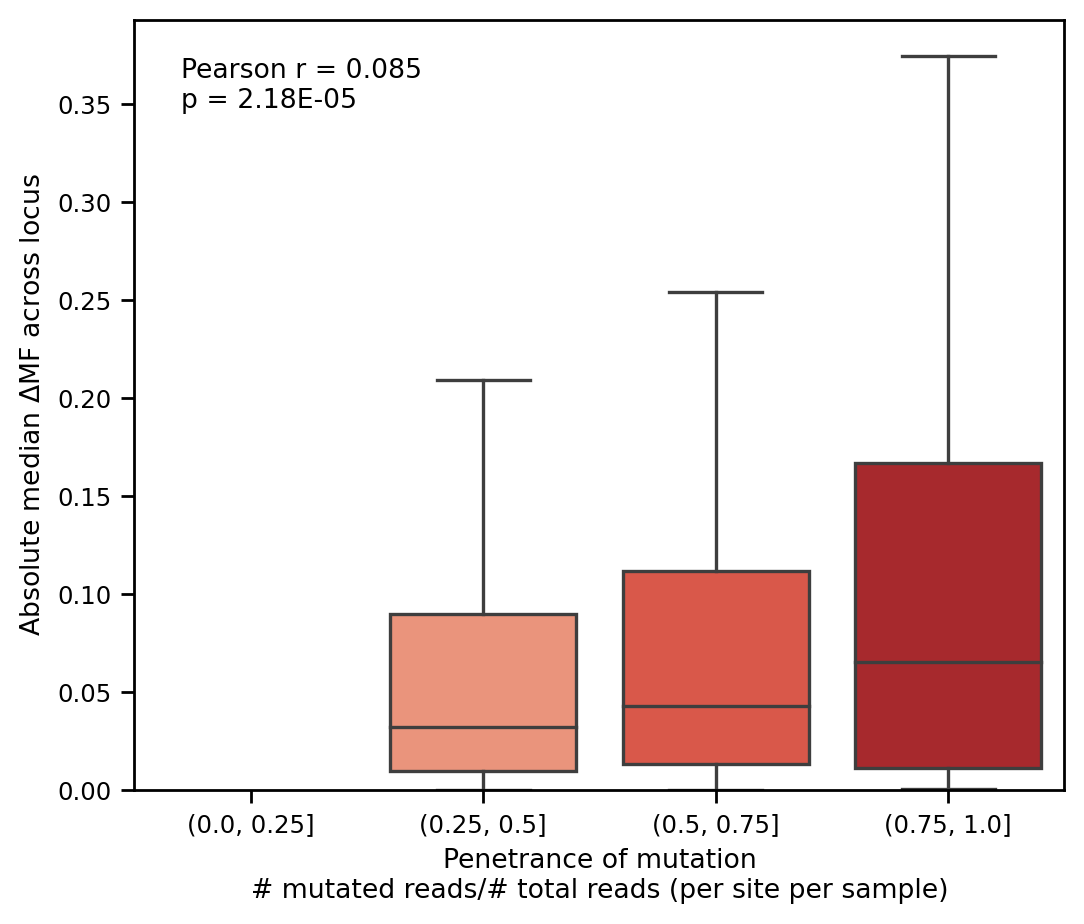

In [134]:
filtered_df = tcga_corr_mean_metrics_w_annot_df.query(
    'distance == 10 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
num_top_muts = int(2484/2) # 25%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
largest_eff_df = pd.concat([top_df, bottom_df])

fig, axes = plt.subplots(figsize = (6,5), dpi = 100)
sns.set_context('paper')

# bin by DNA VAF
largest_eff_df['DNA_VAF_bin'] = pd.cut(
    largest_eff_df['DNA_VAF'],
    bins = pd.IntervalIndex.from_tuples([(0,.25), (.25, .5), (.5, .75), (.75, 1)])
        #[(0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1)])
    )
# get absolute value of median dmf
largest_eff_df['abs_median_dmf'] = largest_eff_df['median_dmf'].abs()
# boxplot
sns.boxplot(
    data=largest_eff_df.query("is_background == False"),
    x='DNA_VAF_bin', y='abs_median_dmf', showfliers=False, palette = 'Reds',
    ax = axes
    )
# corrs, median_abs_dmf is better than abs_median_dmf
print(spearmanr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf']))
print(pearsonr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf']))
# add pearson r and pvalue to upper left corner)
r,p = pearsonr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf'])
# add pearson r and pvalue to upper left corner
axes.text(
    0.05, 0.95, f'Pearson r = {round(r,3)}\np = {p:.2E}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
    )
axes.set_ylabel('Absolute median $\Delta$MF across locus')
axes.set_xlabel('Penetrance of mutation\n# mutated reads/# total reads (per site per sample)')
# include 0 on y axis
axes.set_ylim(bottom=0)
plt.savefig(os.path.join(fig_out_dir, 'supplemental', 'S14_DNAVAF_vs_absDMF_boxplot_corr_TCGA.svg'), dpi = 300, format = 'svg')


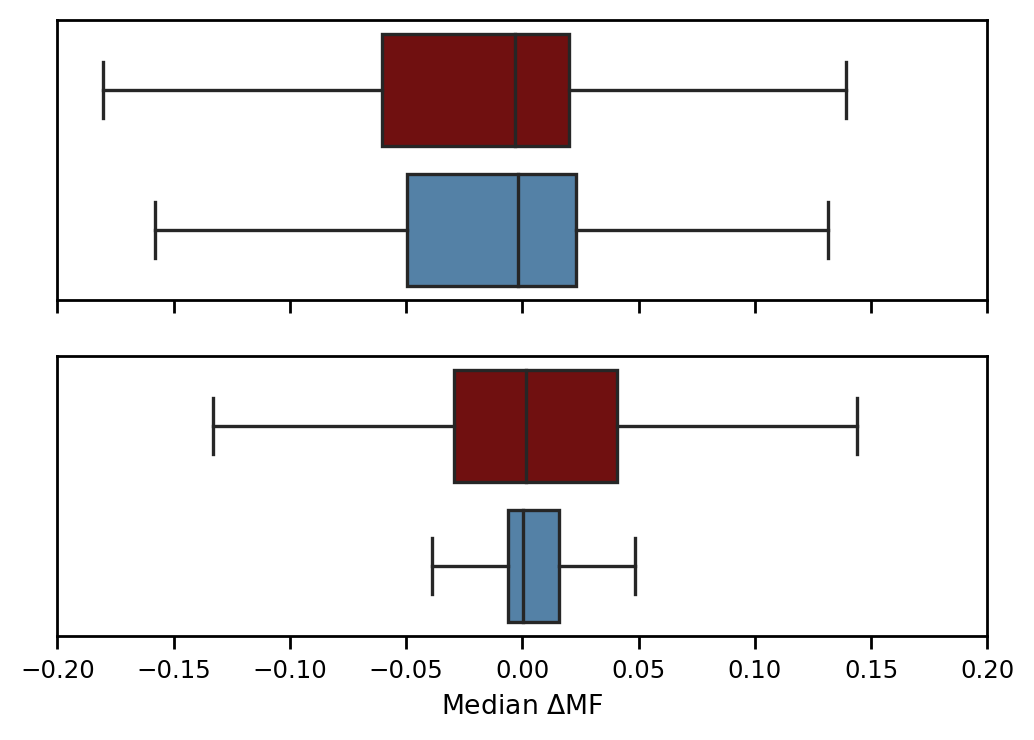

In [30]:
# 5
# make second axes bigger kw
fig, axes = plt.subplots(2,1, figsize = (6, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels

tcga_corr_mean_metrics_w_annot_df['is_cpg'] = tcga_corr_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
tcga_corr_mean_metrics_w_annot_df['is_cpg'] = tcga_corr_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

tcga_corr_mean_metrics_w_annot_df['is_cgi_renamed'] = tcga_corr_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

tcga_corr_mean_metrics_w_annot_df['combined_category'] = tcga_corr_mean_metrics_w_annot_df['is_cpg'] + '\n' + tcga_corr_mean_metrics_w_annot_df['is_cgi_renamed']

mut = tcga_corr_mean_metrics_w_annot_df.loc[tcga_corr_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
        

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

axes[1].set_xlim(-.2, .2)
for i in range(2):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[1].set_xlabel('Median $\Delta$MF')
plt.savefig(os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_figure4D_tcga_boxplots.pdf'), format='svg', dpi = 300)


### Distance of effect

In [33]:
2484*.15

372.59999999999997

In [34]:
372*50

18600

(<Figure size 1000x600 with 4 Axes>,
 array([<Axes: xlabel='Correlation distance (rank order)', ylabel='$\\Delta$MF'>,
        <Axes: xlabel='Genomic distance (kb)'>,
        <Axes: xlabel='Correlation distance (rank order)', ylabel='$\\Delta$MF'>,
        <Axes: xlabel='Genomic distance (kb)'>], dtype=object))

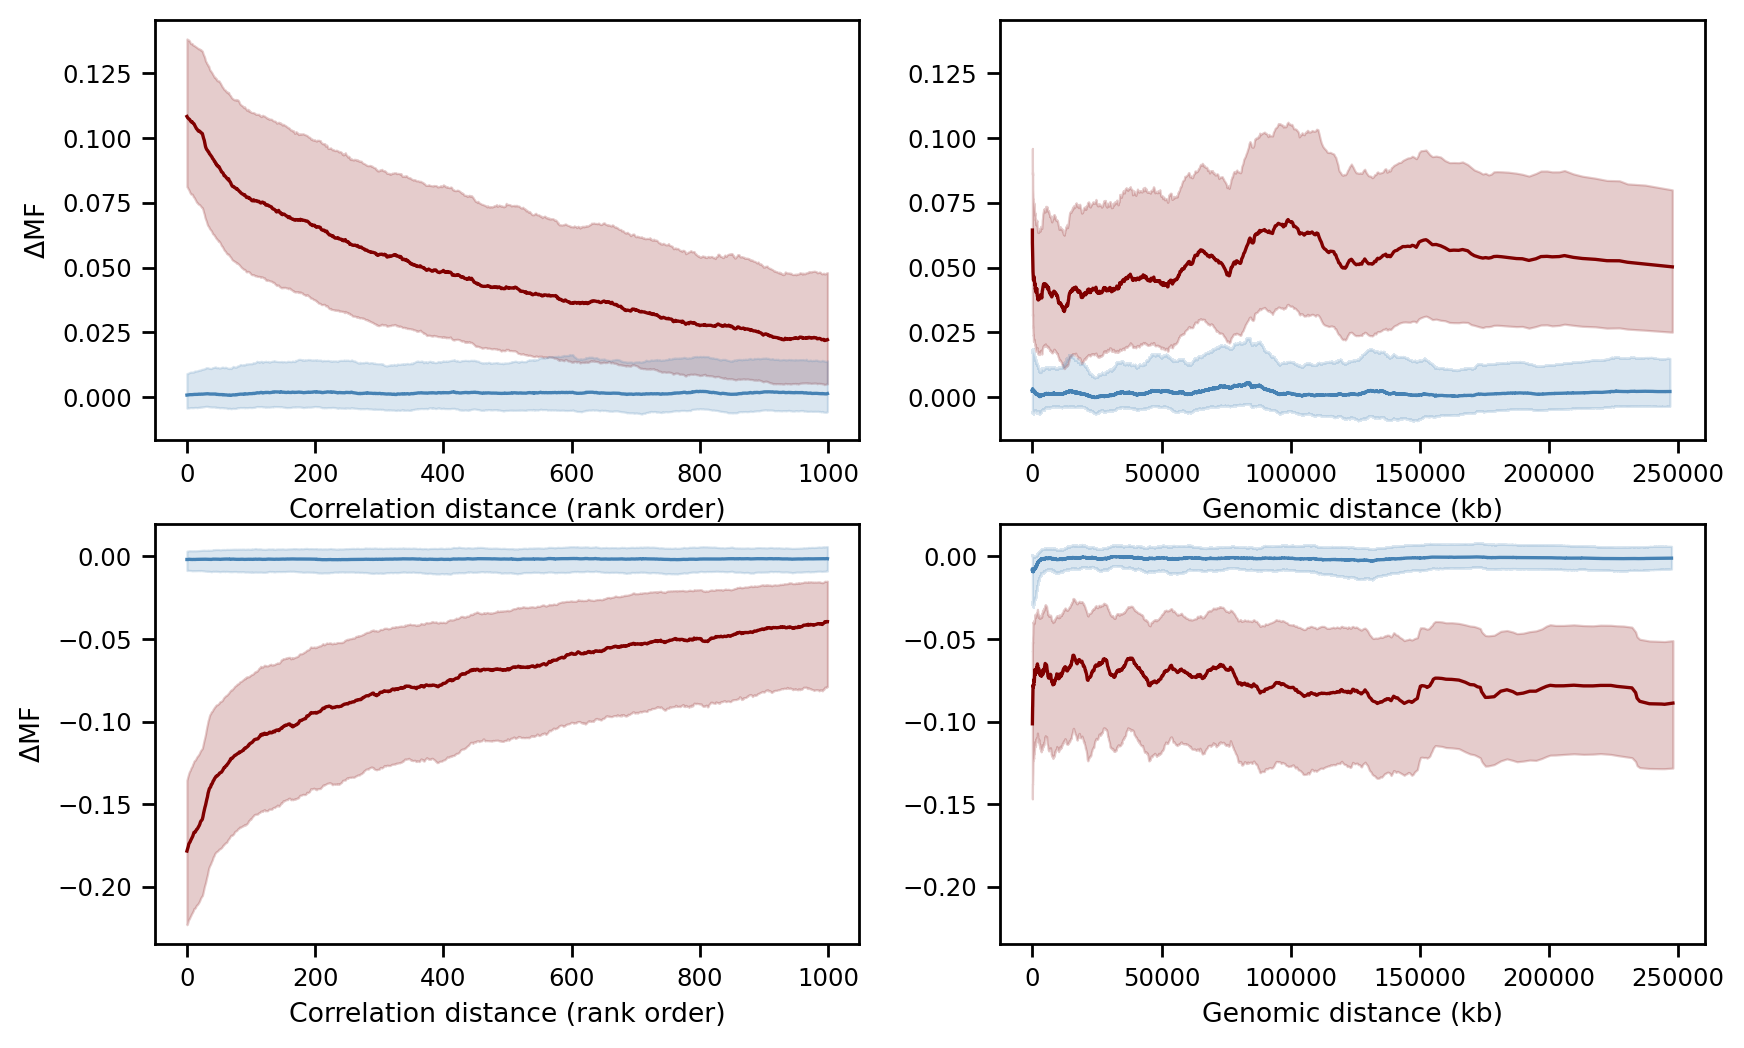

In [35]:
# there are num_top_muts * 1000 rows = 138,000
# and num_top_muts rows for each correlation distance value
# so 10,000 is 
analyze_comethylation.plot_distance_of_effect_lineplot(
    corr_mean_metrics_df.query("distance == 10"), corr_all_metrics_df, num_top_muts = 372, # top15%
    smoothing_window_size_corr = 18600, # num_top_muts * 50
    smoothing_window_size_dist = 18600, 
    dist = 10, plot_bg = True, out_fn =  os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_figure4E_tcga_dist_of_effect.pdf'), 
    corr_vs_dist = True,
    illumina_cpg_locs_df = illumina_cpg_locs_df
    )